# Attempting to improve OCR of Japanese text overlayed on background images

- detection and extraction of foreground text provided an initial seed
- foregound analysis (flow and line detection)
- segmentation of characters from selected line<br>
- improving Tesseract's OCR results with supplimentary CNNs and morphological analysis of text<br>

https://tesseract-ocr.github.io/tessdoc/APIExample

In [1]:
#!tesseract tmp.tif - -l jpn -c lstm_choice_mode=2 hocr

In [2]:
#!jt -t chesterish

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.dpi'] = 300
import warnings
warnings.filterwarnings("ignore")
import os

In [4]:
cv2.__version__

'4.4.0'

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.text_cell_render h1 { font-size: 3.0em; }</style>"))

# Internals

based on the description from https://en.wikipedia.org/wiki/A*_search_algorithm

In [6]:
class Node(object):
    global internal_grid
    def __init__(self,x,y):
        if internal_grid[y][x] is None:
            self.x = x
            self.y = y
            self.g = 0
            self.f = 0
            self.h = 0
            self.opened = False
            self.closed = False
            self.parent = None
            internal_grid[y][x] = self
            #for y in internal_grid:
            #    print(y)
            #print("NEW")
            #print()
        else:
            copy = internal_grid[y][x]
            self.x = copy.x
            self.y = copy.y
            self.g = copy.g
            self.f = copy.f
            self.h = copy.h
            self.opened = copy.opened
            self.closed = copy.closed
            self.parent = copy.parent
            #print("OLD")
            #print()
    def __str__(self):
        return str({'x':self.x,'y':self.y,'f':f"{self.f:.2f}"})
    def __repr__(self):
        return str(self)

def gen_neighbours(x,y,grid):
    size_y, size_x = grid.shape[:2]
    neighbours = []
    if x != 0 and grid[y,x-1] == 0:
        neighbours.append(Node(x-1,y))
    if x != size_x - 1 and grid[y,x+1] == 0:
        neighbours.append(Node(x+1,y))
    if y != 0 and grid[y-1,x] == 0:
        neighbours.append(Node(x,y-1))
    if y != size_y - 1 and grid[y+1,x] == 0:
        neighbours.append(Node(x,y+1))
    return neighbours
        
def backtrace(node):
    nodes = []
    build = True
    while node is not None:
        nodes.append((node.x,node.y))
        node = node.parent
    return nodes
    
internal_grid = None
    
def a_star(startX, startY, endX, endY, grid):
    # initialize internal Node grid
    global internal_grid
    int_y, int_x = grid.shape[:2]
    internal_grid = []
    for i in range(0,int_y):
        internal_grid.append([None]*int_x)
        
    endNode = Node(endX,endY)
    
    startNode = Node(startX,startY)
    startNode.g = 0
    startNode.f = 0

    openlist = []
    openlist.append(startNode)
    startNode.opened = True

    
    while len(openlist) > 0:
        # first node has the minimum f value
        node = openlist.pop(0)
        node.closed = True;
        
        if node.x == endNode.x and node.y == endNode.y:
            #print("commence backtrace")
            return backtrace(node)

        neighbours = gen_neighbours(node.x,node.y, grid)
        #print("Neighbours",neighbours)
        l = len(neighbours)
        for i in range(0,l):
            neighbor = neighbours[i]

            if neighbor.closed:
                #print("\tSkipped")
                openlist = sorted(openlist,key=lambda x:x.f)
                #print()
                continue

            x = neighbor.x;
            y = neighbor.y;
            
            ng = node.g + 1

            if not neighbor.opened or ng < neighbor.g:
                neighbor.g = ng
                #print("\tG",neighbor.g)
                
                # using linalg.norm (L2) as heuristic
                weight = 1
                neighbor.h = weight * np.linalg.norm(np.array([abs(x - endX), abs(y - endY)]));
                #print("\tH",f"{neighbor.h:.2f}")
                neighbor.f = neighbor.g + neighbor.h;
                #print("\tF",f"{neighbor.f:.2f}")
                neighbor.parent = node;

                if not neighbor.opened:
                    openlist.append(neighbor)
                    openlist = sorted(openlist,key=lambda x:x.f)
                    #print(openlist)
                    neighbor.opened = True;
                    #print("\tAdded new")
                else:
                    #print("\tRe-sort/Update")
                    openlist = sorted(openlist,key=lambda x:x.f)
            #print()
    return [];

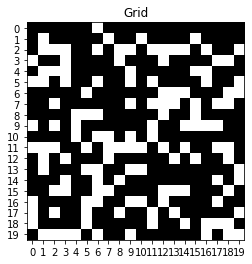

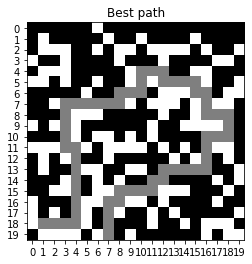

In [7]:
np.random.seed(110)
size_x = 20
size_y = 20
grid = np.reshape(np.where(np.random.rand(size_x*size_y) > 0.7, 1, 0) * 255, (size_y,size_x))
#grid[0,1] = 127
#grid[7,9] = 127
#print(grid)
plt.title('Grid')
plt.xticks(list(range(0,size_x)))
plt.yticks(list(range(0,size_y)))
plt.imshow(grid,cmap="gray")
plt.show()
# 5.45 ms ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each) using sorted()
# %timeit ans = a_star(1,18,7,19,grid)
ans = a_star(1,18,7,19,grid)
for elm in ans:
    grid[elm[1],elm[0]] = 127
plt.title('Best path')
plt.xticks(list(range(0,size_x)))
plt.yticks(list(range(0,size_y)))
plt.imshow(grid,cmap="gray")
plt.show()

In [8]:
def auto_canny(image, sigma=0.83):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print(lower,upper)
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

## Load all images

In [9]:
images = []

number = len(os.listdir('images/'))

for i in range(0,number):
    images.append(cv2.imread('images/image'+f"{i:02}"+'.bmp'))

for i,_ in enumerate(images):
    images[i] = cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)

## Point selection helper

In [10]:
imgselect = 5
img = images[imgselect].copy()
plt.figure(figsize=(45,50))
plt.subplot(141)
plt.title('Original Image')
plt.imshow(img,cmap = 'gray')
plt.show()

In [11]:
def imagepoint(img,imgselect):
    run = True
    
    
    class CoordinateStore:
        def __init__(self,imgselect):
            self.points = []
            self.imgselect = imgselect
            self.run = True

        def select_point(self,event,x,y,flags,param):
            if event == cv2.EVENT_LBUTTONDOWN:
                print(f"'{imgselect}':\n[\n({x},{y}), #{self.imgselect} \n],")
                self.points.append((x,y)) 
                self.run = False
    
    
    store = CoordinateStore(imgselect)
    
    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', store.select_point)

    imgo = cv2.cvtColor(img,cv2.COLOR_RGB2BGR)

    while store.run:
        cv2.imshow('Image', imgo)

        k = cv2.waitKey(0)
        
        if k & 0xFF == 27:
            break

    cv2.destroyAllWindows()
    return store.points

In [12]:
imagepoint(img,imgselect)

'5':
[
(34,32), #5 
],


[(34, 32)]

In [13]:
cv2.destroyAllWindows()

# Character segmentation

In [14]:
def segment(improved,select,min_contour_size,flow='horizontal',single=False,expected=-1):
    #global available_outside
    
    print('SELECT',select)
    
    using = improved.copy()

    contours, hierarchy = cv2.findContours(using, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    shape = (*(improved.shape),3)
    initial = np.zeros(shape,dtype=np.uint8)
    #print('blank shape',blank.shape)
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        a = cv2.contourArea(contours[i])
        boxes.append((x,y,w,h,a,i))
        if a > min_contour_size:
            if hierarchy[0][i][3] == -1:
                cv2.drawContours(initial, contours, i, (255, 0, 0), -1,hierarchy=hierarchy,maxLevel=2)


    sorted_boxes = sorted(boxes,key=lambda x:x[2],reverse=True)

    def merge(A,elements):
        trigg = 0
        for x2,y2,w2,h2,ii,a2 in elements:
            B = (x2,y2,w2,h2)
            d,C = box_relation(A,B)
            if d == 0:
                A = C
            else:
                trigg += 1
            if trigg == 7:
                break
        return A
    
    
    try:
        width = next((x[2] for x in sorted_boxes if x[3]/x[2] > 0.5 and x[3]/x[2] < 2))
    except:
        return improved.shape, [], [], [], []
    height = 0
    M = None
    #for idx,(x1,y1,w1,h1,_,_) in enumerate(boxes):
    #    for x2,y2,w2,h2,_,_ in boxes[idx:]:
    #        d, C = box_relation((x1,y1,w1,h1),(x2,y2,w2,h2))
    #        if d == 0:
    #            if 0.9 < C[3]/C[2] < 1.3:
    #                old_width = width
    #                old_height = height
    #                width = max(width,C[2])
    #                height = max(height,C[3])
    #                if old_width != width or old_height != height:
    #                    M = C

    tmp = np.zeros_like(improved)
    if M is not None:
        cv2.rectangle(tmp,(M[0],M[1]),(M[0]+M[2],M[1]+M[3]),255,3)
    else:
        M = sorted_boxes[0][:4]
        cv2.rectangle(tmp,(M[0],M[1]),(M[0]+M[2],M[1]+M[3]),255,3)
    plt.imshow(tmp,cmap='gray')
    plt.show()
    
    
    height += 2 # one pixel larger on all sides
    width += 2

    print('WIDTH',width)
    print('HEIGHT',height)

    lines = []
    line = []
    inside = False

    for i,y in enumerate(initial):
        count = np.sum(y)
        if count > 0 and not inside:
            if i != 0:
                #line.append(i-1)
                line.append(i)
            else:
                line.append(0)
            inside = True
        elif inside and count == 0:
            inside = False
            line.append(i)
            lines.append(tuple(line))
            line = []
            inside = False

            
    
    #print(lines)
    #print(len(lines))
    remove = []
    for i in range(len(lines)):
        start,end = lines[i]
        line = initial[start:end,:]
        plt.figure(figsize=(15,9))
        plt.imshow(line,cmap='gray')
        plt.title("LINE "+str(i+1)+" size "+str(end-start))
        plt.show()
        if end-start < max(expected,20):
            remove.append(i)


    if remove:
        for x in sorted(remove, reverse=True):
            del lines[x]
            
    if single:
        try:
            lines = [x for x in lines if x[0] <= select[1] <= x[1]]
        except IndexError as e:
            print(e)
            print('The selected point is outside the viewable area')
            return None,None,None,None
        
    if single:
        plt.figure(figsize=(15,9))
        plt.imshow(initial[lines[0][0]:lines[0][1],:],cmap='gray')
        plt.title("ON LINE")
        plt.show()

        
    image_collection = []
    elm_collection = []
    
        
    constraints = []
    
    for selected_line in lines:
        arranged = [x for x in boxes if x[1] >= selected_line[0] and x[1]+x[3] <= selected_line[1] and x[4] > min_contour_size]
        arranged = sorted(arranged,key=lambda x:x[0]) # TODO
        
        plt.figure(figsize=(15,9))
        current_line = initial[selected_line[0]:selected_line[1],:]
        plt.imshow(current_line,cmap='gray')
        plt.title("CURRENT")
        plt.show()
        #####################################################################

        internal = initial.copy()

        #####################################################################
        # TESTING
        #internal = test
        #####################################################################

        line = []
        for i,y in enumerate(cv2.cvtColor(current_line,cv2.COLOR_RGB2GRAY).T):
            if np.sum(y) > 0:
                line.append(i-1)
                break
        last = len(arranged)
        searching = True
        i = 0
        j = 1
        plt.figure(figsize=(50,15))
        max_line = 10
        line_nums = int(np.ceil(len(arranged)/max_line))
        internal_count = 1
        #print('max_line',max_line)
        #print('line_nums',line_nums)
        #print('all',len(arranged))
        x1,y1,w1,h1,_,_ = arranged[i] # first contour
        while searching:
            if j >= last:
                break
            x2,y2,w2,h2,_,_ = arranged[j] # second contour
            minx = min(x1,x2)
            maxx = max(x1+w1,x2+w2)
            miny = min(y1,y2)
            maxy = max(y1+h1,y2+h2)
            check = internal[miny:maxy,minx:maxx] # viewport on both

            check = cv2.cvtColor(check,cv2.COLOR_RGB2GRAY)

            #if maxy-miny > height:
            #    j = j + 1
            #    continue

            for x3,col in enumerate(check.T): # get first empty column
                if np.sum(col) == 0:
                    break
            if x3 > 0 and x3 < check.shape[1] - 1: # do not add it if it's the first or last in viewport
                check = cv2.cvtColor(check,cv2.COLOR_GRAY2RGB)
                check[:,x3] = [255,255,0]
                check[:,x2-1-minx] = [255,255,0]
                #print('good',internal_count)
                plt.subplot(line_nums,max_line,internal_count)
                plt.imshow(check,cmap='gray')
                plt.title("GOOD")
                internal_count += 1
                #plt.show()   

                #cv2.line(blank,(minx+x3,miny),(minx+x3,maxy),(255,255,0))
                #cv2.line(blank,(x2-1,miny),(x2-1,maxy),(255,255,0))

                line.append(minx+x3) # add line to x3 from start of viewport (x3 being the first empty column)
                line.append(x2-1) # add line right before the second contour
                i = j
                j = i+1 # mark the second index to be the end of the first contour
                x1,y1,w1,h1,_,_ = arranged[i] # second contour becomes first
            else:
                grid = check.copy()
                check = cv2.cvtColor(check,cv2.COLOR_GRAY2RGB)
                quick_fix = False
                if check.shape[1]-1 >= width:
                    if check.shape[1] < width*1.1:
                        quick_fix = True
                    min_inspect = grid.shape[1]//2
                    inspect = width
                    check[:,inspect] = [0,0,255]
                    #print('bad',internal_count)
                    plt.subplot(line_nums,max_line,internal_count)
                    plt.imshow(check,cmap='gray')
                    internal_count += 1
                    best_path = None
                    
                    step = (inspect - min_inspect)//5
                    
                    if int(np.round(check.shape[1]/width)) >= 2:
                        middle = minx+min_inspect
                        line.append(middle)
                        line.append(middle)
                        check[:,inspect] = [255,0,0]
                        plt.subplot(line_nums,max_line,internal_count)
                        plt.title('Warning! Slip in half')
                        plt.imshow(check,cmap="gray")
                        internal_count += 1
                        i = j
                        j = i+1
                        x1,y1,w1,h1,_,_ = arranged[i]
                        continue
                    while inspect >= min_inspect:
                        print('PATHFINDING',minx,maxx,inspect,min_inspect,True)
                        if grid[0,inspect] == 0 and grid[grid.shape[0]-1,inspect] == 0:
                            ans = a_star(inspect,0,inspect,grid.shape[0]-1,grid)
                            if len(ans) > 0:
                                if best_path is None:
                                    best_path = ans
                                    inspect -= step
                                    if quick_fix:
                                        inspect = min_inspect - 1
                                elif len(ans) < len(best_path):
                                    best_path = ans
                                    inspect -= step
                                else:
                                    inspect = min_inspect - 1
                            else:
                                inspect -= step
                        else:
                            inspect -= step
                        if inspect < min_inspect:
                            #plt.title(f"BAD {(check.shape[1]//width + 1)} but fixable")
                            print('TERMINATE')
                            if best_path is not None:
                                ans = best_path
                            else:
                                ans = []
                            plt.title(f"BAD {(check.shape[1]//width + 1)}")
                            for elm in ans:
                                grid[elm[1],elm[0]] = 127
                            plt.subplot(line_nums,max_line,internal_count)
                            plt.title('Best path')
                            plt.imshow(grid,cmap="gray")
                            internal_count += 1
                            if len(ans) > 0:
                                left_x = grid.shape[1]
                                right_x = 0
                                for x0,_ in ans:
                                    if x0 < left_x:
                                        left_x = x0
                                    if x0 > right_x:
                                        right_x = x0
                                middle = minx+left_x+(right_x-left_x)//2
                                line.append(middle)
                                line.append(middle)
                                i = j
                                j = i+1
                                x1,y1,w1,h1,_,_ = arranged[i]
                            else:
                                middle = minx+min_inspect
                                line.append(middle)
                                line.append(middle)
                                check[:,inspect] = [255,0,0]
                                plt.subplot(line_nums,max_line,internal_count)
                                plt.title('Warning! Slip in half')
                                plt.imshow(check,cmap="gray")
                                internal_count += 1
                                i = j
                                j = i+1
                                x1,y1,w1,h1,_,_ = arranged[i]
                            break
                        #else:
                        #    inspect -= 1
                            #plt.title(f"BAD {(check.shape[1]//width + 1)} not easily fixable")
                            #if int(np.round(check.shape[1]/width)) == 2:
                            #    middle = minx+inspect
                            #    line.append(middle)
                            #    line.append(middle)
                            #    check[:,inspect] = [255,0,0]
                            #    plt.subplot(line_nums,max_line,internal_count)
                            #    plt.title('Warning! Slip in half')
                            #    plt.imshow(check,cmap="gray")
                            #    internal_count += 1
                            #    i = j
                            #    j = i+1
                            #    x1,y1,w1,h1,_,_ = arranged[i]
                            #else:
                            #    j = j + 1
                            #    x1 = minx
                            #    y1 = miny
                            #    w1 = maxx-minx
                            #    h1 = maxy-miny
                else: # in case it's not the correct width we add an extra contour to the viewport
                    j = j + 1
                    x1 = minx
                    y1 = miny
                    w1 = maxx-minx
                    h1 = maxy-miny
        plt.show()   

        for i,y in enumerate(cv2.cvtColor(current_line,cv2.COLOR_RGB2GRAY).T[::-1]): # add line to the end
            if np.sum(y) > 0:
                line.append(current_line.shape[1]-i)
                break       

        partitioned = np.zeros(shape,dtype=np.uint8)
        for p,(x,y,w,h,a,i) in enumerate(arranged):
            if hierarchy[0][i][3] == -1:
                cv2.drawContours(partitioned, contours, i, (255, 0, 0), -1,hierarchy=hierarchy,maxLevel=2)

        for l in line:
            partitioned[:,l] = [255,255,0]

        plt.figure(figsize=(15,9))
        plt.imshow(partitioned,cmap='gray')
        plt.title("PARTITIONED")
        plt.show()
        #return None,None,None,None,None

        trigger = False
        
        i = 0
        j = 1
        elm = []
        last = len(line)
        prev_spacing = 0
        trigger = False
        while True:
            if j >= last:
                break
            #print(len(elm))
            #print(i,j,line[j]-line[i],width)
            if line[j] - line[i] > width:
                if j - i != 1:
                    if j - i < 5:
                        if line[j]-line[i] > width*1.1:
                            if len(elm) > 0:
                                tmp = elm[-1]
                                del elm[-1]
                                start = tmp[0]
                                end = tmp[1]
                                x = j - 4
                                best = line[j-2]-start
                                idx = j - 2
                                while x > 0 and line[x] > start:
                                    d = abs((line[x]-start) - (line[j-2]-line[x+1]))
                                    if d < best:
                                        best = d
                                        idx = x
                                    x -= 2
                                    
                                elm.append((tmp[0],line[idx],tmp[2],tmp[3],tmp[4]))
                                elm.append((line[idx],line[j-2],tmp[2],tmp[3],tmp[4]))
                                i = j - 1
                                
                                #if 0.9*width < line[j-2]-line[i-2] < width*1.1:
                                #    print('what')
                                #    
                                #    elm.append((tmp[0],line[i-3],tmp[2],tmp[3],tmp[4]))
                                #    elm.append((line[i-2],line[j-2],selected_line[0],selected_line[1],False))
                                #    i = j - 1
                                #    j = i + 1
                                #else:
                                #    print('W0',line[j-2]-line[i-2])
                                #    elm.append((line[i],line[j-2],selected_line[0],selected_line[1],False))
                                #    i = j - 1
                            else:
                                #print('W')
                                elm.append((line[i],line[j-2],selected_line[0],selected_line[1],False))
                                i = j - 1
                        else:
                            #print('W1')
                            #if 0.9*width < line[j-2]-line[j-4] < 1.1*width:
                            #    elm.append((line[i],line[j-4],selected_line[0],selected_line[1],False))
                            #    elm.append((line[j-3],line[j-2],selected_line[0],selected_line[1],False))
                            #else:
                            elm.append((line[i],line[j],selected_line[0],selected_line[1],False))
                            i = j + 1
                            j = i + 1
                    else:
                        inter_spacing = line[j-3]-line[j-4]
                        spacing = line[j-1]-line[j-2]
                        if inter_spacing > spacing:
                            if line[j-4]-line[i] < 0.7*width:
                                elm.append((line[i],line[j-2],selected_line[0],selected_line[1],False))
                                i = j - 1
                            else:
                                elm.append((line[i],line[j-4],selected_line[0],selected_line[1],False))
                                #i = j - 1
                                i = j - 3
                                j = i + 1
                        else:
                            elm.append((line[i],line[j-2],selected_line[0],selected_line[1],False))
                            i = j - 1
                    #j = i + 1
                else: # when we fail via pathfinding (we just cut the section in half)
                    #trigger = True
                    print('Error',i,j)
                    elm.append((line[i],line[j],selected_line[0],selected_line[1],False))
                    i = j+1
                    j = i+1
                    
                    #break
                    #raise
                    #return None, None, None, None
                    
                    #midpoint = (line[j] - line[i])//2
                    #elm.append((line[i],line[i]+midpoint))
                    #elm.append((line[i]+midpoint,line[j]))
                    #i = i + 2
                    #j = j + 2
            else:
                j = j + 2
            #print('POS',i,j)
        #print(last)
        #print(i)
        #print(j)
        if (j-2) > i:
            elm.append((line[i],line[j-2],selected_line[0],selected_line[1],False))
        
        #if trigger:
        #    continue



        save_index = [i for i,x in enumerate(elm) if x[0] <= select[0] <= x[1]]
        if not save_index and single:
            distance = shape[1]
            for i,x in enumerate(elm):
                if abs(select[0] - x[0]) < distance:
                    distance = abs(select[0] - x[0])
                    save_index = i
                if abs(select[0] - x[1]) < distance:
                    distance = abs(select[0] - x[1])
                    save_index = i
        elif save_index:
            save_index = save_index[0]
        else:
            save_index = 0

        #left = save_index
        #right = len(elm) - save_index + 1

        #factor_blue = 255//left
        #factor_red = 255//right
        factor_blue = 128
        factor_red = 128

        blue = 255
        red = 255

        segmented = np.zeros(shape,dtype=np.uint8)

        for p,e in enumerate(elm):
            blue -= factor_blue
            blue = 255 if blue < 0 else blue
            red -= factor_red
            red = 255 if red < 0 else red
            for x,y,w,h,_,i in arranged:
                if e[0] < x+(w//2) < e[1]:
                    if hierarchy[0][i][3] == -1:
                        if p < save_index:
                            cv2.drawContours(segmented, contours, i, (0, 0, blue), -1,hierarchy=hierarchy,maxLevel=2)
                            segmented = cv2.putText(segmented, str(p), (x,y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.4, [255,255,0])
                        elif p > save_index:
                            cv2.drawContours(segmented, contours, i, (red, 0, 0), -1,hierarchy=hierarchy,maxLevel=2)
                            segmented = cv2.putText(segmented, str(p), (x,y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.4, [255,255,0])
                        else:
                            cv2.drawContours(segmented, contours, i, (0, 255, 0), -1,hierarchy=hierarchy,maxLevel=2)
                            segmented = cv2.putText(segmented, str(p), (x,y+h), cv2.FONT_HERSHEY_SIMPLEX, 0.4, [255,255,0])
                elif x+w//2 > e[1]:
                    break


        plt.figure(figsize=(15,9))
        plt.imshow(segmented,cmap='gray')
        #circle = plt.Circle(select, 1, color='w')
        #plt.gcf().gca().add_artist(circle)
        plt.title("SEGMENTED")
        plt.show()
        print("Number of elements: ",len(elm))
        print("Selected element index: ",save_index)
        #exmpl = np.int8(exmpl)

        if len(elm) < 2:
            continue
            #return None, None, None, None


        if flow == 'vertical':
            probable_spacing = elm[1][0]-elm[0][1]
            probable_width = elm[0][1]-elm[0][0]
            probable_height = selected_line[1]-selected_line[0]
            size = max(probable_height,probable_width)
            # switch the values around because we are rotating
            full_image = np.zeros((size,size*len(elm)+(len(elm)-1)*probable_spacing),dtype=np.uint8)
            for idx,e in enumerate(elm):
                draw_on = np.zeros_like(improved)
                min_x = improved.shape[1]
                min_y = improved.shape[0]
                max_x = 0
                max_y = 0
                for x,y,w,h,_,i in arranged:
                    if e[0] < x+(w//2) < e[1]:
                        if hierarchy[0][i][3] == -1:
                            offset = np.array((x,y)) * -1
                            cv2.drawContours(draw_on,contours,i,255,-1,hierarchy=hierarchy,maxLevel=2)#,offset=tuple(offset))
                            min_x = min(min_x,x)
                            min_y = min(min_y,y)
                            max_x = max(max_x,x+w)
                            max_y = max(max_y,y+h)

                constraints.append((min_x,min_y,max_x-min_x,max_y-min_y))
                center = np.array((min_x+(max_x-min_x)//2,min_y+(max_y-min_y)//2))
                real_center = np.array((size//2,size//2))
                move = real_center-center
                T = np.float32([[1, 0, move[0]], [0, 1, move[1]]]) 
                empty = cv2.warpAffine(draw_on, T, (size, size))
                #plt.title((max_y-min_y)/(max_x-min_x))
                #plt.imshow(empty)
                #plt.show()
                if (max_y-min_y)/(max_x-min_x) < 0.25:
                    print('INDEX',idx,'CHOUON') 
                    M = cv2.getRotationMatrix2D(tuple(real_center),0,1)
                    empty = cv2.warpAffine(empty, M, (size, size))
                else:
                    M = cv2.getRotationMatrix2D(tuple(real_center),-90,1)
                    empty = cv2.warpAffine(empty, M, (size, size))
                    elm[idx] = (elm[idx][0],elm[idx][1],elm[idx][2],elm[idx][3],True)
                empty = np.uint8(empty)
                full_image[:,(size+probable_spacing)*idx:(size+probable_spacing)*idx+size] = empty

            plt.figure(figsize=(15,9))
            plt.title("Rotated -90°")
            plt.imshow(full_image,cmap='gray')
            plt.show()
            blank = full_image
            spacing = probable_spacing
        else:
            spacing = width//2
            #if elm[1][0] - elm[0][1] > spacing:
            blank = np.zeros_like(improved)
            blank = np.uint8(blank)
            min_x = improved.shape[1]
            min_y = improved.shape[0]
            max_x = 0
            max_y = 0
            for p,e in enumerate(elm):
                for x,y,w,h,_,i in arranged:
                    if e[0] < x+(w//2) < e[1]:
                        if hierarchy[0][i][3] == -1:
                            cv2.drawContours(blank, contours, i, 255, -1,hierarchy=hierarchy,maxLevel=2,offset=(p*spacing*-1,0))
                            min_x = min(min_x,x)
                            min_y = min(min_y,y)
                            max_x = max(max_x,x+w)
                            max_y = max(max_y,y+h)
                    elif x+w//2 > e[1]:
                        break
                        
                constraints.append((min_x,min_y,max_x-min_x,max_y-min_y))
            blank = blank[:,0:blank.shape[1]-(len(elm)-1)*spacing]
            start = elm[0][0]
            end = elm[-1][1]-(len(elm)-1)*spacing
            
            #plt.figure(figsize=(15,9))
            #plt.title("Fix Spacing")
            #plt.imshow(blank,cmap='gray')
            #plt.show()
            #else:
            #    blank = improved
            #    start = elm[0][0]
            #    end = elm[-1][1]
            blank = blank[selected_line[0]:selected_line[1],start:end]
        # RESIZE
        scale = 50/blank.shape[0]
        new_width = blank.shape[1]*scale
        blank = cv2.resize(blank,(int(new_width),50))
        
        image_collection.append(blank)
        elm_collection.append(elm)

    #available_outside = image_collection
    bigger_h = 0
    elm = []
    for e in elm_collection:
        elm.extend(e)
    
    #cv2.imwrite('save_image.png',padded)
    
    return improved.shape, elm, constraints, contours, hierarchy

# Drawing utilities

In [15]:
def drawCEGimage(imgsize,elm,contours,hierarchy,charspacing=10,padding=30):
    flow = 'horizontal'
    widths = []
    for e in elm:
        if e[-1]:
            flow = 'vertical'
        widths.append(e[1]-e[0])
        
        
    width = np.mean(np.array(widths))
    
    boxes = []
        
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        a = cv2.contourArea(contours[i])
        boxes.append((x,y,w,h,a,i))
    arranged = boxes
    arranged = sorted(arranged,key=lambda x:x[0]*x[1])
    
    if len(elm) < 2:
        return np.zeros(imgsize)
    probable_spacing = elm[1][0]-elm[0][1]
    probable_width = elm[0][1]-elm[0][0]
    probable_height = elm[0][3]-elm[0][2]
    size = max(probable_height,probable_width)
    if flow == 'vertical':
        # switch the values around because we are rotating
        full_image = np.zeros((size,size*len(elm)+(len(elm)-1)*charspacing),dtype=np.uint8)
        for idx,e in enumerate(elm):
            draw_on = np.zeros((imgsize[0],imgsize[1]+charspacing*len(elm)))
            min_x = imgsize[1]
            min_y = imgsize[0]
            max_x = 0
            max_y = 0
            for x,y,w,h,_,i in arranged:
                if e[0] < x+(w//2) < e[1] and e[2] < y+(h//2) < e[3]:
                    if hierarchy[0][i][3] == -1:
                        offset = np.array((x,y)) * -1
                        cv2.drawContours(draw_on,contours,i,255,-1,hierarchy=hierarchy,maxLevel=2)#,offset=tuple(offset))
                        min_x = min(min_x,x)
                        min_y = min(min_y,y)
                        max_x = max(max_x,x+w)
                        max_y = max(max_y,y+h)

            center = np.array((min_x+(max_x-min_x)//2,min_y+(max_y-min_y)//2))
            real_center = np.array((size//2,size//2))
            move = real_center-center
            T = np.float32([[1, 0, move[0]], [0, 1, move[1]]]) 
            empty = cv2.warpAffine(draw_on, T, (size, size))
            #plt.title((max_y-min_y)/(max_x-min_x))
            #plt.imshow(empty)
            #plt.show()
            if (max_y-min_y)/(max_x-min_x) < 0.25:
                print('INDEX',idx,'CHOUON?') 
                M = cv2.getRotationMatrix2D(tuple(real_center),0,1)
                empty = cv2.warpAffine(empty, M, (size, size))
            else:
                M = cv2.getRotationMatrix2D(tuple(real_center),-90,1)
                empty = cv2.warpAffine(empty, M, (size, size))
                elm[idx] = (elm[idx][0],elm[idx][1],elm[idx][2],elm[idx][3],True)
            empty = np.uint8(empty)
            full_image[:,(size+charspacing)*idx:(size+charspacing)*idx+size] = empty

        #plt.figure(figsize=(15,9))
        #plt.title("Rotated -90°")
        #plt.imshow(full_image,cmap='gray')
        #plt.show()
        blank = full_image
        spacing = probable_spacing
    else:
        blank = np.zeros(imgsize)
        blank = np.uint8(blank)

        full_image = np.zeros((size,size*len(elm)+(len(elm)-1)*charspacing),dtype=np.uint8)
        for idx,e in enumerate(elm):
            draw_on = np.zeros((imgsize[0],imgsize[1]+charspacing*len(elm)))
            min_x = imgsize[1]
            min_y = e[2]
            max_x = 0
            max_y = e[3]
            for x,y,w,h,_,i in arranged:
                if e[0] < x+(w//2) < e[1] and e[2] < y+(h//2) < e[3]:
                    if hierarchy[0][i][3] == -1:
                        cv2.drawContours(draw_on,contours,i,255,-1,hierarchy=hierarchy,maxLevel=2)#,offset=tuple(offset))
                        min_x = min(min_x,x)
                        #min_y = min(min_y,y)
                        max_x = max(max_x,x+w)
                        #max_y = max(max_y,y+h)

            #plt.imshow(draw_on)
            #plt.show()
            center = np.array((min_x+(max_x-min_x)//2,min_y+(max_y-min_y)//2))
            real_center = np.array((size//2,size//2))
            move = real_center-center
            T = np.float32([[1, 0, move[0]], [0, 1, move[1]]]) 
            empty = cv2.warpAffine(draw_on, T, (size, size))
            #plt.title((max_y-min_y)/(max_x-min_x))
            #plt.imshow(empty)
            #plt.show()
            empty = np.uint8(empty)
            full_image[:,(size+charspacing)*idx:(size+charspacing)*idx+size] = empty
        #plt.imshow(full_image)
        #plt.show()
    blank = full_image
    start = 0
    end = (size+charspacing)*idx+size
    blank = blank[:,start:end]

    # RESIZE
    scale = 50/blank.shape[0]
    new_width = blank.shape[1]*scale
    blank = cv2.resize(blank,(int(new_width),50))
    #plt.figure(figsize=(50,20))
    #plt.subplot(141)
    #plt.axis('off')
    #plt.imshow(blank,cmap='gray')
    #plt.show()
    
    padded = np.zeros(np.array(blank.shape)+2*padding,dtype=np.uint8)
    padded[padding:padding+blank.shape[0],padding:padding+blank.shape[1]] = blank
    #print(padded.dtype)
    padded = np.bitwise_not(padded)
    plt.figure(figsize=(15,9))
    plt.axis('off')
    plt.imshow(padded,cmap='gray')
    plt.show()
    return padded

In [16]:
def returnCEGindex(elm,select):
    for i,e in enumerate(elm):
        if e[0] <= select[0] <= e[1] and e[2] <= select[1] <= e[3]:
            return i
    return -1

In [17]:
def generateSingleChar(index,imagesize,elm,contours,hierarchy):
    boxes = []
    for i in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        a = cv2.contourArea(contours[i])
        boxes.append((x,y,w,h,a,i))
    arranged = boxes
    arranged = sorted(arranged,key=lambda x:x[0]*x[1])

    # these are specified in the OCR training file
    fontsize = 64
    full_size = fontsize + fontsize//2
    midpoint = full_size // 2

    #empty = np.zeros((full_size,full_size))

    draw_on = np.zeros((imagesize[0],imagesize[1]))

    e = elm[index]
    min_x = imagesize[1]
    min_y = imagesize[0]
    max_x = 0
    max_y = 0
    for x,y,w,h,_,i in arranged:
        if e[0] < x+(w//2) < e[1] and e[2] < y+(h//2) < e[3]:
            if hierarchy[0][i][3] == -1:
                offset = np.array((x,y)) * -1
                cv2.drawContours(draw_on,contours,i,255,-1,hierarchy=hierarchy,maxLevel=2)#,offset=tuple(offset))
                min_x = min(min_x,x)
                min_y = min(min_y,y)
                max_x = max(max_x,x+w)
                max_y = max(max_y,y+h)
    #plt.imshow(draw_on,cmap='gray')
    #plt.show()
    center = np.array((min_x+(max_x-min_x)//2,min_y+(max_y-min_y)//2))
    real_center = np.array((full_size//2,full_size//2))
    move = real_center-center
    T = np.float32([[1, 0, move[0]], [0, 1, move[1]]]) 
    empty = cv2.warpAffine(draw_on, T, (full_size, full_size))

    empty = np.uint8(empty)

    empty = cv2.warpAffine(draw_on, T, (full_size, full_size))
    
    if e[4]: # rotate
        M = cv2.getRotationMatrix2D(tuple(real_center),-90,1)
        print(M)
        empty = cv2.warpAffine(empty, M, (full_size, full_size))
        empty = np.uint8(empty)

    #empty = cv2.cvtColor(empty,cv2.COLOR_GRAY2RGB)
    current_size = sum((max_x-min_x,max_y-min_y))//2
    #print(current_size)
    scale = 64//current_size
    if scale == 0:
        scale = np.ceil(current_size/64)
        print(f"Downscale {scale}x")
        # FIXME if it's bigger it needs to be shrunk
        blank = cv2.resize(empty,tuple(np.uint8(np.array(empty.shape,dtype=np.float16)/scale)),interpolation=cv2.INTER_NEAREST)

    else:
        print(f"Rescale {scale}x")
        blank = cv2.resize(empty,tuple(np.array(empty.shape)*scale),interpolation=cv2.INTER_NEAREST)
    #print(blank.shape)
    #print((full_size,full_size))

    axis = blank.shape[0]//2
    blank = blank[axis-midpoint:axis+midpoint,axis-midpoint:axis+midpoint]
    #print(blank.shape)
    empty = blank
    empty = np.uint8(empty)
    empty = cv2.cvtColor(empty,cv2.COLOR_GRAY2RGB)
    print(empty.shape)

    plt.imshow(empty,cmap='gray')
    plt.show()
    return empty

## Tesseract helper

In [18]:
def call_tesseract(elm,T=[7,13]):
    from importlib import reload
    import jishox
    reload(jishox)
    import xml.etree.ElementTree as ET
    import subprocess
    import shlex
    #T = [1,3,7,13]
    #T = [7,13]
    datapoints = []
    maxhits = 0
    for X in T:
        subprocess.check_output(f"convert save_image.png tmp.tif && tesseract tmp.tif - -l jpn --psm {X} -c lstm_choice_mode=2 hocr > result.horc",shell=True)
        try:
            ns = {'xhtml': 'http://www.w3.org/1999/xhtml'} # add more as needed
            tree = ET.parse('result.horc')
            root = tree.getroot()
            line = root.find('xhtml:body/xhtml:div/xhtml:div/xhtml:p/xhtml:span',ns) # first line (the only line)
            info = []
            for idx,char in enumerate(line.findall("xhtml:span[@class='ocrx_word']",ns)):
                info.append({'literal':char.text.strip(),'conf':int(char.get('title').split("x_wconf ")[1])})
            print(info)
            datapoints.append(info)
            maxhits = max(maxhits,len(info))
        except AttributeError as e:
            print(e)
            continue
        except:
            continue
    return datapoints

# Extraction

In [19]:
class Color(object):
    RED = (0xB2, 0x2B, 0x31)
    GREEN = (0x00,0xA2,0x50)
    BLUE = (0x1F,0x8F,0xFB)
    ORANGE = (0xDD,0xB6,0x2B)
    MAGENTA = (0xA0,0x31,0x96)
    CYAN = (0x25,0x8F,0x8F)
    YELLOW = (0xEA,0xF5,0x10)
    WHITE = (0xFF,0xFF,0xFF)
    BLACK = (0x00,0x00,0x00)

def split(image,clusters):
    
    if np.isin(0,image[:,:,3]):
        print("ALPHA")
        clusters += 1
    
    samples = image.reshape(-1,4).astype(np.float32)

    retval, labels, centers = cv2.kmeans(samples, clusters,  None, (cv2.TERM_CRITERIA_EPS, 30, 0.1),  3,  cv2.KMEANS_PP_CENTERS)
    centers = np.uint8(centers)
    quant = centers[labels.flatten()]
    quant = quant.reshape((image.shape))
    
    colors = centers
    
    #print('ALL COLORS',colors)
    
    index = np.where(np.all(colors == np.array([0,0,0,0]),axis=1))
    colors = np.delete(colors,index,axis=0) # Remove excluded color
    
    #print('REMAINING',colors)

    red = quant[:,:,0]
    green = quant[:,:,1]
    blue = quant[:,:,2]
    
    splits = []
    for c in colors:
        color1 = np.uint8((red == c[0]) & (green == c[1]) & (blue == c[2]))*255
        splits.append(color1)
    return splits

def box_relation(X,Y):
    (x1,y1,w1,h1),(x2,y2,w2,h2) = X,Y
    dist_x = min(abs(x1-(x2+w2)), abs(x2-(x1+w1)))
    dist_y = min(abs(y1-(y2+h2)), abs(y2-(y1+h1)))
    min_x = min(x1,x2)
    max_x = max(x1+w1,x2+w2)
    min_y = min(y1,y2)
    max_y = max(y1+h1,y2+h2)
    if max_x-min_x > w1+w2:
        if max_y-min_y > h1+h2:
            dist = np.sqrt(dist_x**2 + dist_y**2)
        else:
            dist = dist_x
    elif max_y-min_y > h1+h2:
        dist = dist_y
    else:
        dist = 0 #Relation.INTERSECT
    A = (min_x,min_y,max_x-min_x,max_y-min_y)
    return dist,A

def box_area(X):
    (x1,y1,w1,h1) = X
    return w1*h1

def return_center(X):
    (x1,y1,w1,h1) = X
    center = (x1+w1//2,y1+h1//2)
    return center

def merge(A,elements):
    trigg = 0
    for x2,y2,w2,h2,ii,a2 in elements:
        B = (x2,y2,w2,h2)
        d,C = box_relation(A,B)
        if d == 0:
            A = C
        else:
            trigg += 1
        if trigg == 7:
            break
    return A


# this is actually line deduction (not character discovery)
def discovery(image,elements,X):
    H = X
    V = X
    (x,y,w,h,a) = X
    
    min_x = x
    max_x = x+w
    min_y = y
    max_y = y+h

    horizontal_spacing = []
    vertical_spacing = []
    expected_collection_h = []
    expected_collection_v = []
    
    p_w = w
    p_h = h
    
    #up_d = np.zeros_like(image)
    #cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.RED,3)  
    for x2,y2,w2,h2,ii in elements:#[closest_index:]:
        B = (x2,y2,w2,h2)
        X = B
        if y2 <= y <= y2+h2 or y2 <= y+h <= y2+h2 or (y <= y2 and y2+h2 <= y+h) or (y >= y2 and y2+h2 >= y+h):
            if y2 != 0 and y2+h2 != image.shape[0] and x2 != 0 and x2+w2 != image.shape[1]:
                if y < return_center((B))[1] < y+h:
                    state = 1
                    if h2 > h*1.1 and not (y <= return_center(B)[1] <= y+h and h2 < h*1.5):
                        continue

                    # LEFT
                    if x2+w2 < min_x:
                        dist = abs(min_x-(x2+w2))
                        if dist < 2.0*w:
                            min_x = x2
                            if w2 > p_w:
                                p_w = w2
                            horizontal_spacing.append(dist)
                        else:
                            #print('LEFT')
                            state = 3
                    # RIGHT
                    elif x2 > max_x:
                        dist = abs(max_x-x2)
                        if dist < 2.0*w:
                            max_x = x2+w2
                            if w2 > p_w:
                                p_w = w2
                            horizontal_spacing.append(dist)
                        else:
                            #print('RIGHT')
                            state = 3
                    # OVERLAP TOWARDS RIGHT
                    elif x2 <= max_x and x2+w2 >= max_x:
                        dist = abs(max_x-(x2+w2))
                        if dist < w*1.2:
                            max_x = max(x2+w2,max_x)
                        else:
                            #print('OVER RIGHT')
                            state = 3
                    # OVERLAP TOWARDS LEFT
                    elif x2 <= min_x and x2+w2 >= min_x:
                        dist = abs(min_x-x2)
                        if dist < w*1.2:
                            min_x = min(x2,min_x)
                        else:
                            #print('OVER LEFT')
                            state = 3
                    # OVERLAP
                    elif x2 >= min_x and x2+w2 <= max_x:
                        pass
                    else:
                        state = 2
                else:
                    state = 0
            else:
                state = 2
                
            if state == 1:
                if w2 > H[2] and h2 > H[3]:
                    H = B
            #if state == 0:
            #    cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.ORANGE,3)  
            #if state == 1:
            #    cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.BLUE,3)  
            #if state == 2:
            #    cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.WHITE,3)  
            #if state == 3:
            #    cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.GREEN,3)  
            #plt.figure(figsize=(20,20))
            #plt.imshow(up_d)
            #plt.show()
                
            expected_collection_h.append((x2,y2,w2,h2,ii,None,state))
        if x2 <= x <= x2+w2 or x2 <= x+w <= x2+w2 or (x <= x2 and x+w >= x2+w2) or (x >= x2 and x+w <= x2+w2):
            if y2 != 0 and y2+h2 != image.shape[0] and x2 != 0 and x2+w2 != image.shape[1]:
                if x < return_center((B))[0] < x+w:
                    state = 1
                    if w2 > w*1.1 and not (x <= return_center(B)[0] <= x+w and w2 < w*1.5):
                        continue

                    # TOP
                    if y2+h2 < min_y:
                        dist = abs(min_y-(y2+h2))
                        if dist < 2.0*h:
                            min_y = y2
                            if h2 > p_h:
                                p_h = h2
                            vertical_spacing.append(dist)
                        else:
                            state = 3
                    # BOTTOM
                    elif y2 > max_y:
                        dist = abs(max_y-y2)
                        if dist < 2.0*h:
                            max_y = y2+h2
                            if h2 > p_h:
                                p_h = h2
                            vertical_spacing.append(dist)
                        else:
                            state = 3
                    # OVERLAP TOWARDS BOTTOM
                    elif y2 <= max_y and y2+h2 >= max_y:
                        dist = abs(max_y-(y2+h2))
                        if dist < h*1.2:
                            max_y = max(y2+h2,max_y)
                        else:
                            state = 3
                    # OVERLAP TOWARDS TOP
                    elif y2 <= min_y and y2+h2 >= min_y:
                        dist = abs(min_y-y2)
                        if dist < h*1.2:
                            min_y = min(y2,min_y)
                        else:
                            state = 3
                    # OVERLAP
                    elif y2 >= min_y and y2+h2 <= max_y:
                        pass
                    else:
                        state = 2
                else:
                    state = 0
            else:
                state = 2

            if state == 1:
                if w2 > V[2] and h2 > V[3]:
                    V = B
            expected_collection_v.append((x2,y2,w2,h2,ii,None,state))
    return expected_collection_h,expected_collection_v






def extraction(image,select,sharp=False,erode=False):

    if sharp:
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        image = cv2.filter2D(image, -1, kernel)
    
    kernel = np.ones((3,3),np.uint8)
    i = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    edges = cv2.morphologyEx(i,cv2.MORPH_GRADIENT,kernel) 
    edges = cv2.threshold(edges,edges.mean(),255,cv2.THRESH_BINARY)[1]
    
    plt.figure(figsize=(50,20))
    plt.subplot(141)
    plt.title("Show "+str(image.shape[:2]))
    plt.axis('off')
    plt.imshow(image)

    plt.subplot(142)
    plt.title("Gradient")
    circle = plt.Circle(select, 4, color='r')
    plt.gcf().gca().add_artist(circle)
    plt.axis('off')
    plt.imshow(edges,cmap="gray")

    plt.subplot(143)
    plt.title("Canny")
    c = auto_canny(i)
    plt.axis('off')
    #grayscale = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #plt.imshow(grayscale,cmap="gray")
    plt.imshow(c,cmap="gray")
    
    #plt.title("Sharpened")
    #plt.axis('off')
    #kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    #sharp = cv2.filter2D(image, -1, kernel)
    #plt.imshow(sharp,cmap="gray")
    plt.show()
    
    # ratio, area , distance, coverage # this is also stated at the bottom
    valid = [np.inf,np.inf,np.inf,0]
    best_image = None

    def analyze_split(title,image,full,select):
        
        global datapoints
        global save_for_later
        global forced_dilation
        global imgselect
        global greyscale

        main_title = f'{title}'
        
        print()
        print('#'*20)
        print(main_title)
        print('VALID',valid)
        
        #############################################################################################################################################################
        # FIND CLOSEST CONTOUR
        #############################################################################################################################################################
        
        
        if erode > 0 and forced_dilation == 0:
            element = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
            full = cv2.morphologyEx(full,cv2.MORPH_ERODE,element,iterations=erode)
        elif forced_dilation > 0:
            element = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
            full = cv2.morphologyEx(full,cv2.MORPH_DILATE,element,iterations=forced_dilation)
            forced_dilation = 0
            print('FORCED DILATION')
        
        
        contours, hierarchy = cv2.findContours(full, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        #empty = cv2.cvtColor(np.zeros_like(full),cv2.COLOR_GRAY2RGB)
        if not contours:
            print('No contours')
            return None
        arranged = []
        boxes = []
        for i in range(len(contours)):
            if hierarchy[0][i][3] == -1:
                dist = cv2.pointPolygonTest(contours[i],select,True)
                if dist > 0.0:
                    dist = 0.0
                x,y,w,h = cv2.boundingRect(contours[i])
                
                #info = cv2.minAreaRect(contours[i])
                #boxes.append((info,i))
                
                #box = np.int0(cv2.boxPoints(info))
                ##cv2.drawContours(rects, [box], 0, Color.BLUE, 2)
                # cv2.polylines(rects, [box], True, Color.BLUE, 2) 
                
                a = cv2.contourArea(contours[i])
                arranged.append((x,y,w,h,i,a,abs(dist)))

        distances = sorted(arranged,key=lambda x:x[-1])
        closest_index = 0
        composite = False
        while True:
            x,y,w,h,i,a,d = distances[closest_index]
            if x == 0 or x+w == image.shape[1] or y == 0 or y+h == image.shape[0] or np.isclose(a,0.0): # FIXME isclose based on some heuristic not 0.0
                if distances[closest_index][-1] < 5:
                    composite = True
                closest_index += 1
                if closest_index > len(distances) - 1:
                    closest_index = 0
                    print(f"No suitable contour found for {main_title}")
                    return None
                    break
            else:
                break
        print('DISTANCE',distances[closest_index][-1])
        
        
        ###################################################################### 
        ###################################################################### 
        ###################################################################### 
        ############################# START ################################## 
        ###################################################################### 
        ###################################################################### 
        ###################################################################### 
        ###################################################################### 
            
        rects_h = np.zeros_like(image)
        rects_v = np.zeros_like(image)
        
        high_ratio = 1.4
        low_ratio = 0.85
        perfect_ratio = low_ratio + abs(high_ratio-low_ratio)/2
        
        scale = 3
        A = (x,y,w,h)
        print('ELEMENT RATIO',h/w)
        radius_of_observation = (max(w,h)//2)*scale
        
        I = A # SAVE INITIAL BOX
        INITIAL = A
        INITIAL_AREA = a
        
        N = None
        
        elements = sorted(arranged,key=lambda x:box_relation(A,(x[0],x[1],x[2],x[3]))[0])
        
        for xA,yA,wA,hA,iA,aA,dA in elements:
            if yA == 0 or yA+hA == image.shape[0] or xA == 0 or xA+wA == image.shape[1]:
                cv2.rectangle(rects_h,(xA,yA),(xA+wA,yA+hA),Color.YELLOW,1)  
            else:
                cv2.rectangle(rects_h,(xA,yA),(xA+wA,yA+hA),Color.BLUE,1)  
        
        if N is not None:
            cv2.rectangle(rects_h,(N[0],N[1]),(N[0]+N[2],N[1]+N[3]),Color.YELLOW,1)  
        cv2.rectangle(rects_h,(I[0],I[1]),(I[0]+I[2],I[1]+I[3]),Color.MAGENTA,1)  
        
        center = return_center((x,y,w,h))
        cv2.rectangle(rects_h,(x,y),(x+w,y+h),Color.RED,1)  
        cv2.circle(rects_h, center, radius_of_observation//scale, Color.CYAN, 1)
        cv2.circle(rects_h, center, radius_of_observation, Color.RED, 1)
        
        
        ratio = h/w
        
        A = (x,y,w,h)
        
        trigger = 0
        final_check = False
        outside = 0
        
        
        tried = []
        succeded = []
        single = False
        
        X = A
        tmp_ratio = 0
        x_dist = radius_of_observation
        z_dist = 0
        G = [] # grace collection
        
        save_initial = False
        if ratio < 0.3 or ratio > 3:
            save_initial = True
            INITIAL = A
            
        overcompensation = 0
        
        GOOD_ATTEMPTS = []
        
        #save_for_later.append((full,elements,A,select))
        
        intercharacter_spacing = 0
        
        
            
        ALL = []
        #ALL.append((A,h/w,0))
        cur_ratio = h/w
        LIST = [A]
        
        tries = 0
        better = False
        
        outside = 0
        
        MINSIZE = 5
        
        selected = 0
        
        
        #########################
        #########################
        # DISCOVERY
        #########################
        #########################
        
        if not low_ratio <= ratio <= high_ratio or (w < MINSIZE and h < MINSIZE):
            for x2,y2,w2,h2,ii,a2,d2 in elements:
                
                if y2 == 0 or y2+h2 == image.shape[0] or x2 == 0 or x2+w2 == image.shape[1]:
                    continue
                    
                    
                tried.append(ii)
                B = (x2,y2,w2,h2)
                dist,C = box_relation(A,B)
                print('ATTEMPT',C[3]/C[2])
                if (a/100 > a2 or a2/100 > a) and dist != 0:
                    print('SKIPPING BECAUSE OF SIZE...')
                    continue
                #if A[2] < MINSIZE and A[3] < MINSIZE and dist > radius_of_observation:
                #    print('JUMP TO CLOSEST')
                #    A = B
                #    radi
                if dist < radius_of_observation:
                    
                    A = C
                    succeded.append(ii)
                    #if A[2] < MINSIZE and A[3] < MINSIZE:
                    #    A = C
                    new_ratio = C[3]/C[2]
                    print('NEW',new_ratio)
                    if final_check:
                        #if overcompensation == 3:
                        #    A = GOOD_ATTEMPTS[0]
                        #    print('STOPPED ADDING...')
                        #    break
                        if abs(perfect_ratio-new_ratio) < abs(perfect_ratio-tmp_ratio) and x_dist*2 > dist and dist != 0:
                            tmp_ratio = new_ratio
                            A = C
                            GOOD_ATTEMPTS.append((A,tmp_ratio))
                            print('FINAL CHECK, BUT BETTER RATIO...')
                        elif dist == 0:
                            print('INTERSECT, NOT FINAL...')
                        else:
                            print('FINAL CHECK...')
                            break
                        overcompensation += 1
                    if low_ratio <= new_ratio <= high_ratio:
                        bigger = max(A[2],A[3])
                        if low_ratio <= B[3]/B[2] <= high_ratio and (bigger*0.8 < B[2] < bigger*1.2 or bigger*0.8 < B[3] < bigger*1.2):
                            print('JUMP SHIP')
                            A = B
                            break
                        print('GOOD RATIO')
                        #a = a + a2
                        tmp_ratio = new_ratio
                        if dist != 0:
                            x_dist = dist
                            if dist > intercharacter_spacing:
                                intercharacter_spacing = dist
                        A = C
                        break ##ADDED
                        
                        final_check = True
                        GOOD_ATTEMPTS.append((A,tmp_ratio))
                    else:
                        bigger = max(A[2],A[3])
                        if low_ratio <= B[3]/B[2] <= high_ratio and (bigger*0.8 < B[2] < bigger*1.2 or bigger*0.8 < B[3] < bigger*1.2):
                            print('JUMP SHIP')
                            A = B
                            break
                        if abs(perfect_ratio-new_ratio) > abs(perfect_ratio-ratio) or (new_ratio < 0.5 or new_ratio > 2):
                            print('TRIGGER',trigger)
                            trigger += 1
                        if trigger == 3:
                            if ratio < 0.3 or ratio > 3:
                                print('NOT STANDARD...')
                                break
                            else:
                                print('NOT 一')
                                #return None
                                break
                else:
                    if low_ratio <= B[3]/B[2] <= high_ratio:
                        if B[3]*B[2] > A[3]*A[2]:
                            G.append((B,dist))
                    if dist != 0:
                        outside += 1
                    if outside == 3:
                        if G:
                            print('THERE MIGHT BE VALID CHARACTERS...')
                            B = None
                            D = max(image.shape[:2])
                            for b,d in G:
                                if d < D:
                                    B = b
                                    D = d
                            if B is not None:
                                A = B
                                elements = sorted(arranged,key=lambda x:box_relation(A,(x[0],x[1],x[2],x[3]))[0])
                            break
                        if low_ratio < A[3]/A[2] < high_ratio:
                            single = True
                            print('SINGLE CHARACTER...')
                            return None
                        print('TERMINATED...')
                        return None
                    
        ICHI = False
                
        (x,y,w,h) = A
        ratio = h/w
        if ratio < 0.3 or ratio > 3:
            size = max(w,h)//2
            x1,y1 = return_center(A)
            if x1-size < 0 or x1+size > image.shape[1] or y1-size < 0 or y1+size > image.shape[0]:
                if save_initial:
                    A = INITIAL
                    (x,y,w,h) = A
                    size = max(w,h)//2
                    x1,y1 = return_center(A)
                    if x1-size < 0 or x1+size > image.shape[1] or y1-size < 0 or y1+size > image.shape[0]:
                        print('STILL CLIPPING...')
                        return None
                else:
                    print('BUT CLIPPING...')
                    return None
            if x1-3*size < 0 and x1+3*size > image.shape[1] and y1-3*size < 0 and y1+3*size > image.shape[0]:
                if save_initial:
                    A = INITIAL
                    (x,y,w,h) = A
                    size = max(w,h)//2
                    x1,y1 = return_center(A)
                    if x1-3*size < 0 and x1+3*size > image.shape[1] and y1-3*size < 0 and y1+3*size > image.shape[0]:
                        print('STILL ONLY SINGLE CHAR POSSIBLE...')
                        return None
                else:
                    print('ONLY SINGLE CHAR POSSIBLE...')
                    return None
            ORIG = A
            A = (x1-size,y1-size,size*2,size*2)
            (x,y,w,h) = A
            ICHI = True
            print('ICHI OR CHOUON !!')
        
        composite = False
        print('COMPOSITE',composite)
        if not composite:
            #if distances[closest_index][-1] > max(w,h):
            #    print('EXEEDED DISTANCE FROM SELECTION...')
            #    return None

            #if closest is not None:
            #    if closest > radius_of_observation:
            #        print('TOO FAR AWAY')
            #        return None
            #else:
            #    if not 0.9 <= ratio <= 1.3:
            #        print('NO POSSIBLE TRAVERSAL')
            #        return None

            print('PROBABLE RATIO',h/w)
            print('INTERCHARACTER SPACING',intercharacter_spacing)

            radius_of_observation = (max(w,h)//2)*scale

            print('HEIGHT',h)
            print('WIDTH',w)


            if w < MINSIZE or h < MINSIZE:
                print('TOO SMALL...')
                return None

            for xA,yA,wA,hA,iA,aA,dA in distances[closest_index:]:
                if iA in tried:
                    if iA in succeded:
                        cv2.rectangle(rects_v,(xA,yA),(xA+wA,yA+hA),Color.MAGENTA,1)  
                    else:
                        cv2.rectangle(rects_v,(xA,yA),(xA+wA,yA+hA),Color.ORANGE,1)  
                else:
                    cv2.rectangle(rects_v,(xA,yA),(xA+wA,yA+hA),Color.BLUE,1)  

            center = return_center(A)

            dimY = 100
            dimX = 100
            extract = rects_v[max(0,center[1]-dimY):min(rects_v.shape[0],center[1]+dimY),max(0,center[0]-dimX):min(rects_v.shape[1],center[0]+dimX)]

            cv2.rectangle(rects_v,(x,y),(x+w,y+h),Color.RED,1)  

            cv2.circle(rects_v, center, radius_of_observation//scale, Color.CYAN, 1)
            cv2.circle(rects_v, center, radius_of_observation, Color.RED, 1)

            empty = np.zeros_like(image)
            step = 255//len(distances)
            step = max(1,step)
            current = 0
            for _,_,_,_,ix,_,_ in distances:
                cv2.drawContours(empty, contours, ix, (255-current, 0, current) , -1,hierarchy=hierarchy,maxLevel=2)
                current += step
                current = min(255,current)

            plt.figure(figsize=(50,20))
            plt.subplot(141)
            plt.title('DISTANCES')
            plt.imshow(empty)
            #cv2.imwrite('distances.png',cv2.cvtColor(empty,cv2.COLOR_RGB2BGR))
            plt.axis('off')
            plt.subplot(142)
            plt.axis('off')
            plt.title('BOXES H')
            plt.imshow(rects_h)
            #cv2.imwrite('first.png',cv2.cvtColor(rects_h,cv2.COLOR_RGB2BGR))
            plt.subplot(143)
            plt.axis('off')
            plt.title('BOXES V')
            plt.imshow(rects_v)
            #cv2.imwrite('second.png',cv2.cvtColor(rects_v,cv2.COLOR_RGB2BGR))
            plt.subplot(144)
            plt.axis('off')
            plt.title('EXTRACT')
            plt.imshow(extract)
            plt.show()

            ###################################################################### 
            ###################################################################### 
            ###################################################################### 
            ###################################################################### 
            ###################################################################### 
            ###################################################################### 
            ###################################################################### 
            ###################################################################### 

            #print(distances)
            #if distances[closest_index][0] > 10 and not composite:
            #    print("IS NOT COMPOSITE")
            #    return None



            empty = np.zeros_like(image)




            #############################################################################################################################################################
            # COLLECT CONTOURS THAT ARE HORIZONTALLY / VERTICALLY ADJACANT TO THE SELECTED
            #############################################################################################################################################################
            expected_collection_h = []
            expected_collection_v = []
            unexpected = []

            #def elemental_search(A):
            #(x,y,w,h) = A

            min_x = x
            max_x = x+w
            min_y = y
            max_y = y+h

            print('MAX HORIZONTAL SPACING',2*w)
            print('MAX VERTICAL SPACING',2*h)

            remove = []
            tmp_left = -1,0
            tmp_right = -1,0

            horizontal_spacing = []
            vertical_spacing = []

            H = A
            V = A
            OVP = []

            p_w = w
            p_h = h
            
            for x2,y2,w2,h2,ii,a2,d2 in elements:#[closest_index:]:
                B = (x2,y2,w2,h2)
                if y2 <= y <= y2+h2 or y2 <= y+h <= y2+h2 or (y <= y2 and y2+h2 <= y+h) or (y >= y2 and y2+h2 >= y+h):
                    if y2 != 0 and y2+h2 != image.shape[0] and x2 != 0 and x2+w2 != image.shape[1] and not np.isclose(a2,a/200): # FIXME isclose based on some heuristic not 0.0
                        if y < return_center((B))[1] < y+h and not (y+h)+(y+h)*0.1 < y2+h2:
                            state = 1
                            if ICHI:
                                if ORIG == B:
                                    state = 1
                                else:
                                    d,X = box_relation(A,(x2,y2,w2,h2))
                                    if d == 0 and ORIG[3]/ORIG[2] < 0.3:
                                        continue
                            #y = min(y,y2)
                            #my = max(y+h,y2+h2)
                            #h = my-y
                            if h2 > h*1.1 and not (y <= return_center(B)[1] <= y+h and h2 < h*1.5):
                                continue

                            # LEFT
                            if x2+w2 < min_x:
                                dist = abs(min_x-(x2+w2))
                                if dist < 2.0*w:
                                    min_x = x2
                                    if w2 > p_w:
                                        p_w = w2
                                    horizontal_spacing.append(dist)
                                else:
                                    state = 3
                            # RIGHT
                            elif x2 > max_x:
                                dist = abs(max_x-x2)
                                if dist < 2.0*w:
                                    max_x = x2+w2
                                    if w2 > p_w:
                                        p_w = w2
                                    horizontal_spacing.append(dist)
                                else:
                                    state = 3
                            # OVERLAP TOWARDS RIGHT
                            elif x2 <= max_x and x2+w2 >= max_x:
                                dist = abs(max_x-(x2+w2))
                                if dist < w*1.2:
                                    max_x = max(x2+w2,max_x)
                                else:
                                    state = 3
                            # OVERLAP TOWARDS LEFT
                            elif x2 <= min_x and x2+w2 >= min_x:
                                dist = abs(min_x-x2)
                                if dist < w*1.2:
                                    min_x = min(x2,min_x)
                                else:
                                    state = 3
                            # OVERLAP
                            elif x2 >= min_x and x2+w2 <= max_x:
                                pass
                            else:
                                state = 2
                        else:
                            if ICHI:
                                if ORIG == B:
                                    state = 1
                                else:
                                    d,X = box_relation(A,(x2,y2,w2,h2))
                                    if d == 0:
                                        continue
                                    else:
                                        state = 0
                            else:
                                state = 0
                    else:
                        state = 2
                    if state == 1:
                        if w2 > H[2] and h2 > H[3]:
                            H = B
                    expected_collection_h.append((x2,y2,w2,h2,ii,a2,state))
                if x2 <= x <= x2+w2 or x2 <= x+w <= x2+w2 or (x <= x2 and x+w >= x2+w2) or (x >= x2 and x+w <= x2+w2):
                    if y2 != 0 and y2+h2 != image.shape[0] and x2 != 0 and x2+w2 != image.shape[1] and not np.isclose(a2,a/200): # FIXME isclose based on some heuristic not 0.0
                        if x < return_center((B))[0] < x+w:
                            state = 1
                            if ICHI:
                                if ORIG == B:
                                    state = 1
                                else:
                                    d,X = box_relation(A,(x2,y2,w2,h2))
                                    if d == 0 and ORIG[3]/ORIG[2] > 3:
                                        continue
                            if w2 > w*1.1 and not (x <= return_center(B)[0] <= x+w and w2 < w*1.5):
                                continue
                            #x = min(x,x2)
                            #mx = max(x+w,x2+w2)
                            #w = mx-x

                            # TOP
                            if y2+h2 < min_y:
                                dist = abs(min_y-(y2+h2))
                                if dist < 2.0*h:
                                    min_y = y2
                                    if h2 > p_h:
                                        p_h = h2
                                    vertical_spacing.append(dist)
                                else:
                                    state = 3
                            # BOTTOM
                            elif y2 > max_y:
                                dist = abs(max_y-y2)
                                if dist < 2.0*h:
                                    max_y = y2+h2
                                    if h2 > p_h:
                                        p_h = h2
                                    vertical_spacing.append(dist)
                                else:
                                    state = 3
                            # OVERLAP TOWARDS BOTTOM
                            elif y2 <= max_y and y2+h2 >= max_y:
                                dist = abs(max_y-(y2+h2))
                                if dist < h*1.2:
                                    max_y = max(y2+h2,max_y)
                                else:
                                    state = 3
                            # OVERLAP TOWARDS TOP
                            elif y2 <= min_y and y2+h2 >= min_y:
                                dist = abs(min_y-y2)
                                if dist < h*1.2:
                                    min_y = min(y2,min_y)
                                else:
                                    state = 3
                            # OVERLAP
                            elif y2 >= min_y and y2+h2 <= max_y:
                                pass
                            else:
                                state = 2
                        else:
                            if ICHI:
                                if ORIG == B:
                                    state = 1
                                else:
                                    d,X = box_relation(A,(x2,y2,w2,h2))
                                    if d == 0:
                                        continue
                                    else:
                                        state = 0
                            else:
                                state = 0
                    else:
                        state = 2

                    if state == 1:
                        if w2 > V[2] and h2 > V[3]:
                            V = B
                    expected_collection_v.append((x2,y2,w2,h2,ii,a2,state))


            #### FLOW SELECTION
            
            VERTICAL = 0
            HORIZONTAL = 1
            flow = HORIZONTAL
            
            vertical_max = np.max(vertical_spacing,initial=0)
            horizontal_max = np.max(horizontal_spacing,initial=0)
            
            vertical = np.mean(vertical_spacing)
            horizontal = np.mean(horizontal_spacing)
            
            if np.isnan(vertical):
                vertical = vertical_max
                flow = HORIZONTAL
            else:
                vertical = (vertical+vertical_max)//2
            if np.isnan(horizontal):
                horizontal = horizontal_max
                flow = VERTICAL
            else:
                horizontal = (horizontal+horizontal_max)//2
                
            
            print('FLOW DEDUCTION')
            
                
            
            if vertical < horizontal and max_y-min_y > 2*h:
                if vertical < intercharacter_spacing:
                    print("FAILED SPACING TEST...")
                    return None
                flow = VERTICAL
                #A = V
            elif max_x-min_x > 2*w:
                if horizontal < intercharacter_spacing:
                    print("FAILED SPACING TEST...")
                    return None
                flow = HORIZONTAL
                #A = H
            else:
                print("NOT ENOUGHT CHARACTERS...")
                #image_alpha = cv2.cvtColor(image,cv2.COLOR_RGB2RGBA)
                #selected_alpha = cv2.bitwise_and(image_alpha,image_alpha,mask=full)
                #for i,c in enumerate(split(selected_alpha,2)):
                #    analyze_split(main_title+'-'+str(i+1),image,c,select)
                return None

            try:
                print(w,h)
                print(A)
                C1 = next((x[:4] for x in expected_collection_h if x[:4] != A and (w*0.9 < x[2] < w*1.2 or h*0.9 < x[3] < h*1.2)))
                print(C1)
                C1,_ = box_relation(A,C1)
                C2 = next((x[:4] for x in expected_collection_v if x[:4] != A and (w*0.9 < x[2] < w*1.2 or h*0.9 < x[3] < h*1.2)))
                print(C2)
                C2,_ = box_relation(A,C2)
                print(C1)
                print(C2)
                if C1 < h and C2 < w:
                    if C1 < C2:
                        flow = HORIZONTAL
                    elif C2 < C1:
                        flow = VERTICAL
            except:
                print("FAILED SPECIAL...")
            
            #(x,y,w,h) = A
            print("HORIZONTAL SPACING",horizontal)
            print("VERTICAL SPACING",vertical)
            print('FLOW','horizontal' if flow == HORIZONTAL else 'vertical')


            spacing = np.nanmin([horizontal,vertical])
            if np.isnan(spacing):
                print('ONLY ONE CHARACTER!')
                return None
            else:
                spacing = int(spacing)

            plt.figure(figsize=(50,20))
            plt.subplot(141)
            plt.title(main_title)
            plt.axis('off')
            plt.imshow(full,cmap='gray')
    #
            def reject_outliers(data, m=1):
                return data[abs(data - np.mean(data)) < m * np.std(data)]
    #

            #############################################################################################################################################################
            # DRAW HORIZONTAL TEMP
            #############################################################################################################################################################
            horizontal_draw = np.zeros_like(image)
            miny = y
            maxy = y+h

            baselines = []
            if expected_collection_h:
                for x9,y9,w9,h9,i9,a9,s9 in expected_collection_h:
                    miny = min(miny,y9)
                    maxy = max(maxy,y9+h9)
                    if s9 == 0 and min_x <= x9 and max_x >= x9+w9:
                        cv2.drawContours(horizontal_draw, contours, i9, Color.ORANGE, -1,hierarchy=hierarchy,maxLevel=2)
                    #elif s9 == 1 and y9+h9 <= baseline:
                    #    cv2.drawContours(horizontal_draw, contours, i9, Color.BLUE, -1,hierarchy=hierarchy,maxLevel=2)
                    elif s9 == 1:
                        cv2.drawContours(horizontal_draw, contours, i9, Color.BLUE, -1,hierarchy=hierarchy,maxLevel=2)
                    #    cv2.drawContours(horizontal_draw, contours, i9, Color.MAGENTA, -1,hierarchy=hierarchy,maxLevel=2)
                    elif s9 == 3:
                        cv2.drawContours(horizontal_draw, contours, i9, Color.GREEN, -1,hierarchy=hierarchy,maxLevel=2)
                    else:
                        cv2.drawContours(horizontal_draw, contours, i9, Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)

                cv2.drawContours(horizontal_draw, contours, distances[closest_index][4], Color.RED, -1,hierarchy=hierarchy,maxLevel=2)

                plt.subplot(142)
                plt.title(f"Horizontal")
                plt.imshow(horizontal_draw,cmap='gray')
                plt.axis('off')
                #cv2.imwrite('horizontal.png',cv2.cvtColor(horizontal_draw,cv2.COLOR_RGB2BGR))
                
                
                plt.axhline(y=y,xmin=0,color='r')
                plt.axhline(y=y+h,xmin=0,color='r')
#
                #plt.axhline(y=miny,xmin=0,color='b')
                #plt.axhline(y=maxy,xmin=0,color='b')
#
                plt.axvline(x=x,ymin=0,color='y')
                plt.axvline(x=x+w,ymin=0,color='y')

                plt.axvline(x=min_x,ymin=0,color='b')
                plt.axvline(x=max_x,ymin=0,color='b')
        

            #############################################################################################################################################################
            # DRAW VERTICAL TEMP
            #############################################################################################################################################################
            vertical_draw = np.zeros_like(image)
            minx = x
            maxx = x+w
            if expected_collection_v:
                for x9,y9,w9,h9,i9,a9,s9 in expected_collection_v:
                    minx = min(minx,x9)
                    maxx = max(maxx,x9+w9)
                    if s9 == 0 and min_y <= y9 and max_y >= y9+h9:
                        cv2.drawContours(vertical_draw, contours, i9, Color.ORANGE, -1,hierarchy=hierarchy,maxLevel=2)
                    elif s9 == 1:
                        cv2.drawContours(vertical_draw, contours, i9, Color.BLUE, -1,hierarchy=hierarchy,maxLevel=2)
                    elif s9 == 3:
                        cv2.drawContours(vertical_draw, contours, i9, Color.GREEN, -1,hierarchy=hierarchy,maxLevel=2)
                    else:
                        cv2.drawContours(vertical_draw, contours, i9, Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)

                cv2.drawContours(vertical_draw, contours, distances[closest_index][4], Color.RED, -1,hierarchy=hierarchy,maxLevel=2)

                plt.subplot(143)
                plt.title(f"Vertical")
                plt.imshow(vertical_draw,cmap='gray')
                #cv2.imwrite('vertical.png',cv2.cvtColor(vertical_draw,cv2.COLOR_RGB2BGR))
                plt.axis('off')
                plt.axvline(x=x,ymin=0,color='r')
                plt.axvline(x=x+w,ymin=0,color='r')
                #plt.axvline(x=minx,ymin=0,color='b')
                #plt.axvline(x=maxx,ymin=0,color='b')
                plt.axhline(y=y,xmin=0,color='y')
                plt.axhline(y=y+h,xmin=0,color='y')

                plt.axhline(y=min_y,xmin=0,color='b')
                plt.axhline(y=max_y,xmin=0,color='b')

            
            plt.subplot(144)
            plt.title('DISPLAY')
            plt.axis('off')


            display = np.zeros_like(image)

            
            if flow == VERTICAL:
                # force constraints when it comes to partially included characters (ORANGE)
                ex_right = max([e[0] for e in expected_collection_v if e[-1] == 1])
                ex_left = min([e[0] for e in expected_collection_v if e[-1] == 1])
                for x9,y9,w9,h9,i9,a9,s9 in expected_collection_v:
                    if s9 == 1:
                        cv2.drawContours(display, contours, i9, Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    if s9 == 0:
                        if x9 >= ex_left and x9+w9 <= ex_right:
                            cv2.drawContours(display, contours, i9, Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    #elif s9 == 0 and min_y <= y9 and max_y >= y9+h9:
                    #    cv2.drawContours(display, contours, i9, Color.ORANGE, -1,hierarchy=hierarchy,maxLevel=2)
                    #    w = max(w,w9)
            else:
                #selected = np.array([x[1]+x[3] for x in expected_collection_h])
                #print(selected)
                #selected = reject_outliers(selected)
                #print(selected)
                high = min([e[1] for e in expected_collection_h if e[-1] == 1])
                low = max([e[1] for e in expected_collection_h if e[-1] == 1])
                for x9,y9,w9,h9,i9,a9,s9 in expected_collection_h:
                    if s9 == 1:
                        #if y9+h9 in selected:
                        cv2.drawContours(display, contours, i9, Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    if s9 == 0:
                        if y9 >= high and y9+h9 <= low:
                            cv2.drawContours(display, contours, i9, Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    #elif s9 == 0 and min_x <= x9 and max_x >= x9+w9:
                    #    cv2.drawContours(display, contours, i9, Color.ORANGE, -1,hierarchy=hierarchy,maxLevel=2)
                    #    h = max(h,h9)

            plt.imshow(display)
            plt.show()

                
            adj = full.copy()


            neighbor_line_h = np.zeros_like(image)
            neighbor_line_v = np.zeros_like(image)
            complete = np.zeros_like(image)

            for x2,y2,w2,h2 in OVP:
                cv2.rectangle(complete,(x2,y2),(x2+w2,y2+h2),Color.YELLOW,1)  

            cv2.rectangle(complete,(x,y),(x+w,y+h),Color.RED,1)  
            
            up = []
            down = []
            left = []
            right = []

            max_h = 0
            max_w = 0
            
            for x2,y2,w2,h2,ii,a2,d2 in elements:#[closest_index:]:

                if y2 != 0 and y2+h2 != image.shape[0] and x2 != 0 and x2+w2 != image.shape[1]:

                    if flow == VERTICAL and w2 > p_w*1.2:
                        continue
                    if flow == HORIZONTAL and h2 > p_h*1.2:
                        continue

                    #if low_ratio < h2/w2 < high_ratio:
                    if w*0.9 < w2 < w*1.2 or h*0.9 < h2 < h*1.2:
                        color = Color.YELLOW
                    else:
                        color = Color.BLUE

                    # UP
                    if y2+h2 < y-spacing and y2 > y - 2.5*p_h:
                        #cv2.rectangle(neighbor_line_h,(x2,y2),(x2+w2,y2+h2),Color.BLUE,1)  
                        cv2.rectangle(neighbor_line_h,(x2,y2),(x2+w2,y2+h2),color,1)  
                        up.append((x2,y2,w2,h2,ii))
                        if w*0.9 < w2 < w*1.2 or h*0.9 < h2 < h*1.2:
                            max_h = max(max_h,h2)
                    # DOWN
                    if y2 > y+h+spacing and y2+h2 < y+h + 2.5*p_h:
                        #cv2.rectangle(neighbor_line_h,(x2,y2),(x2+w2,y2+h2),Color.YELLOW,1)  
                        cv2.rectangle(neighbor_line_h,(x2,y2),(x2+w2,y2+h2),color,1)  
                        down.append((x2,y2,w2,h2,ii))
                        if w*0.9 < w2 < w*1.2 or h*0.9 < h2 < h*1.2:
                            max_h = max(max_h,h2)
                    # LEFT
                    if x2 > x-2.5*p_w and x2+w2 < x-spacing:
                        #cv2.rectangle(neighbor_line_v,(x2,y2),(x2+w2,y2+h2),Color.ORANGE,1)  
                        cv2.rectangle(neighbor_line_v,(x2,y2),(x2+w2,y2+h2),color,1)  
                        left.append((x2,y2,w2,h2,ii))
                        if w*0.9 < w2 < w*1.2 or h*0.9 < h2 < h*1.2:
                            max_w = max(max_w,w2)
                            #left.append(x2+w2//2)
                            #left.append()
                    # RIGHT
                    if x2 > x+w+spacing and x2+w2 < x+w + 2.5*p_w:
                        #cv2.rectangle(neighbor_line_v,(x2,y2),(x2+w2,y2+h2),Color.CYAN,1)  
                        cv2.rectangle(neighbor_line_v,(x2,y2),(x2+w2,y2+h2),color,1)  
                        right.append((x2,y2,w2,h2,ii))
                        if w*0.9 < w2 < w*1.2 or h*0.9 < h2 < h*1.2:
                            max_w = max(max_w,w2)

            #for x2,y2,w2,h2,ii in left:
            #    cv2.rectangle(complete,(x2,y2),(x2+w2,y2+h2),Color.BLUE,1)  
                
            plt.figure(figsize=(50,20))
            plt.subplot(141)
            plt.title(f"ADJACANT")
            plt.axis('off')
            #plt.axhline(y=(mean_t-(max_h*1.1)//2),xmin=0,color='w')
            #plt.axhline(y=(mean_b+(max_h*1.1)//2),xmin=0,color='w')
            #plt.axvline(x=(mean_l-(max_w*1.1)//2),ymin=0,color='w')
            #plt.axvline(x=(mean_r+(max_w*1.1)//2),ymin=0,color='w')
            plt.axvline(x=x-2.5*w,ymin=0,color='g')
            plt.axvline(x=x-spacing,ymin=0,color='g')
            plt.imshow(adj,cmap='gray')

            plt.subplot(142)
            plt.title(f"HORIZONTAL")   
            plt.axis('off')
            plt.axhline(y=y,xmin=0,color='y')
            plt.axhline(y=y+h,xmin=0,color='y')
            #plt.axhline(y=mean_t,xmin=0,color='r')
            #plt.axhline(y=mean_b,xmin=0,color='b')
            plt.imshow(neighbor_line_h)

            plt.subplot(143)
            plt.title(f"VERTICAL")   
            plt.axis('off')
            plt.axvline(x=x,ymin=0,color='y')
            plt.axvline(x=x+w,ymin=0,color='y')
            #plt.axvline(x=mean_l,ymin=0,color='b')
            #plt.axvline(x=mean_r,ymin=0,color='r')
            plt.imshow(neighbor_line_v)

            #plt.subplot(144)
            #plt.title(f"COMPLETE")   
            #plt.axis('off')
            #plt.imshow(complete)
            plt.show()
                
            up_d = np.zeros_like(image)
            down_d = np.zeros_like(image)
            left_d = np.zeros_like(image)
            right_d = np.zeros_like(image)
                
                
            #############################                         #####################################
            #############################                         #####################################
            #############################                         #####################################
            #############################                         #####################################
            #############################                         #####################################
            #############################                         #####################################
            #############################                         #####################################
            #############################                         #####################################
            #############################                         #####################################
                
            plt.figure(figsize=(50,20))
                
                
            #print('LEFT')
            similar = 3*max_w
            r_b = x-spacing
            l_b = r_b-max_w
            l_c = 0
            r_c = 0
            L = []
            hits = 0
            for inc in range(0,int(2.5*w-max_w)):
                S = []
                l_b -= 1
                r_b -= 1
                l_c = r_b
                r_c = l_b
                c_hits = 0
                for P in left:
                    if l_b*0.9 <= P[0] and P[0]+P[2] <= r_b*1.1:
                        S.append(P)
                        l_c = min(P[0],l_c)
                        r_c = max(P[0]+P[2],r_c)
                        if w*0.9 < P[2] < w*1.1 or h*0.9 < P[3] < h*1.1:
                            c_hits += 1
                if c_hits > hits:
                    L = S
                    hits = c_hits
                    similar = abs(max_w - (r_c - l_c))
                    #print('SAVED',similar,hits)
                    #print(U)
                    #print()
                elif c_hits == hits and abs(max_w - (r_c - l_c)) < similar:
                    L = S
                    hits = c_hits
                    similar = abs(max_w - (r_c - l_c))
                    #print('SAVED',similar,hits)
                    #print(U)
                    #print()    
                
            L = sorted(L,key=lambda x:x[2]*x[3],reverse=True)
            #print(L)
            try:
                X = next((E for E in L if min_y < E[1] < max_y))
            except:
                X = None
            
            #print('X',X)
            
            #for P in L:
            #    cv2.drawContours(left_d, contours, P[-1], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
            if X is not None:
                I = X
                
                L = sorted(left,key=lambda x:box_relation(X[:4],x[:4])[0])
                hh,vv = discovery(image,L,X)

                for X in vv:
                    #if X[-1] == 0:
                    #    cv2.rectangle(left_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.ORANGE,3)  
                    if X[-1] == 1:
                        #cv2.rectangle(left_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.BLUE,3)  
                        cv2.drawContours(left_d, contours, X[-3], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    #if X[-1] == 2:
                    #    cv2.rectangle(left_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.WHITE,3)  
                    #if X[-1] == 3:
                    #    cv2.rectangle(left_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.MAGENTA,3)  

                #cv2.rectangle(left_d,(I[0],I[1]),(I[0]+I[2],I[1]+I[3]),Color.RED,3)  
            
            plt.subplot(141)
            plt.title(f"LEFT")
            #plt.axis('off')
            #plt.axhline(y=min_y,xmin=0,color='b')
            #plt.axhline(y=max_y,xmin=0,color='r')
            #plt.axvline(x=l_b,ymin=0,color='r')
            #plt.axvline(x=(mean_l+(max_w*1.1)//2),ymin=0,color='r')
            plt.imshow(left_d)
            
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
                
            #print('RIGHT')
            similar = 3*max_w
            l_b = x+w+spacing
            r_b = l_b+max_w
            l_c = 0
            r_c = 0
            R = []
            hits = 0
            for inc in range(0,int(2.5*w-max_w)):
                S = []
                l_b += 1
                r_b += 1
                l_c = r_b
                r_c = l_b
                c_hits = 0
                for P in right:
                    if l_b*0.9 <= P[0] and P[0]+P[2] <= r_b*1.1:
                        S.append(P)
                        l_c = min(P[0],l_c)
                        r_c = max(P[0]+P[2],r_c)
                        if w*0.9 < P[2] < w*1.1 or h*0.9 < P[3] < h*1.1:
                            c_hits += 1
                if c_hits > hits:
                    R = S
                    hits = c_hits
                    similar = abs(max_w - (r_c - l_c))
                    #print('SAVED',similar,hits)
                    #print(U)
                    #print()
                elif c_hits == hits and abs(max_w - (r_c - l_c)) < similar:
                    R = S
                    hits = c_hits
                    similar = abs(max_w - (r_c - l_c))
                    #print('SAVED',similar,hits)
                    #print(U)
                    #print()    
                    
                    
            R = sorted(R,key=lambda x:x[2]*x[3],reverse=True)
            #print(R)
            try:
                X = next((E for E in R if min_y < E[1] < max_y))
            except:
                X = None
            
            #print('X',X)
            
            #for P in R:
            #    cv2.drawContours(right_d, contours, P[-1], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                
            if X is not None:
                I = X
                
                R = sorted(right,key=lambda x:box_relation(X[:4],x[:4])[0])
                hh,vv = discovery(image,R,X)

                for X in vv:
                    #if X[-1] == 0:
                    #    cv2.rectangle(right_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.ORANGE,3)  
                    if X[-1] == 1:
                        #cv2.rectangle(right_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.BLUE,3)  
                        cv2.drawContours(right_d, contours, X[-3], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    #if X[-1] == 2:
                    #    cv2.rectangle(right_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.WHITE,3)  
                    #if X[-1] == 3:
                    #    cv2.rectangle(right_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.MAGENTA,3)  

                #cv2.rectangle(right_d,(I[0],I[1]),(I[0]+I[2],I[1]+I[3]),Color.RED,3)   
                    
                    
            plt.subplot(142)
            plt.title(f"RIGHT")
            #plt.axis('off')
            #plt.axvline(x=r_b,ymin=0,color='r')
            #plt.axvline(x=l_b,ymin=0,color='b')
            #plt.axvline(x=(mean_r+(max_w*1.1)//2),ymin=0,color='r')
            plt.imshow(right_d)
            #plt.imshow(neighbor_line_v)

            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            
            #print('UP')
            #print(y,h,max_h)
            similar = 3*max_h
            b_b = y-spacing
            t_b = b_b-max_h
            t_c = 0
            b_c = 0
            U = []
            hits = 0
            for inc in range(0,int(2.5*h-max_h)):
                S = []
                t_b -= 1
                b_b -= 1
                t_c = b_b
                b_c = t_b
                c_hits = 0
                for P in up:
                    if t_b*0.9 <= P[1] and P[1]+P[3] <= b_b*1.1:
                        S.append(P)
                        t_c = min(P[1],t_c)
                        b_c = max(P[1]+P[3],b_c)
                        if w*0.9 < P[2] < w*1.1 or h*0.9 < P[3] < h*1.1:
                            c_hits += 1
                            
                #print('NORMAL',max_h-(b_c-t_c),c_hits)
                if c_hits > hits:
                    U = S
                    hits = c_hits
                    similar = abs(max_h - (b_c - t_c))
                    #print('SAVED',similar,hits)
                    #print(U)
                    #print()
                elif c_hits == hits and abs(max_h - (b_c - t_c)) < similar:
                    U = S
                    hits = c_hits
                    similar = abs(max_h - (b_c - t_c))
                    #print('SAVED',similar,hits)
                    #print(U)
                    #print()
                #test = np.zeros_like(image)
                #for X in S:
                #    if w*0.9 < X[2] < w*1.1 or h*0.9 < X[3] < h*1.1:
                #        cv2.rectangle(test,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.YELLOW,3)     
                #    else:
                #        cv2.rectangle(test,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.BLUE,3)     
#
                #plt.figure(figsize=(50,20))
                #plt.title('SCAN'+str(c_hits))
                #plt.imshow(test)
                #plt.show()
                    
                
            U = sorted(U,key=lambda x:x[2]*x[3],reverse=True)
            #print(U)
            try:
                X = next((E for E in U if min_x < E[0] < max_x))
            except:
                X = None
            
            #print('X',X)
            
            #for P in U:
                #if w*0.9 < P[2] < w*1.1 or h*0.9 < P[3] < h*1.1:
                #    cv2.rectangle(up_d,(P[0],P[1]),(P[0]+P[2],P[1]+P[3]),Color.YELLOW,1)  
            #    cv2.drawContours(up_d, contours, P[-1], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                
            if X is not None:
                I = X
                
                U = sorted(up,key=lambda x:box_relation(X[:4],x[:4])[0])
                hh,vv = discovery(image,U,X)
                #high = min([e[1] for e in hh])

                for X in hh:
                    #if X[-1] == 0:
                        #cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.ORANGE,3)  
                    #    if X[1] >= high:
                    #        cv2.drawContours(up_d, contours, X[-3], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    if X[-1] == 1:
                    #    cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.BLUE,3)  
                        cv2.drawContours(up_d, contours, X[-3], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    #if X[-1] == 2:
                    #    cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.WHITE,3)  
                    #if X[-1] == 3:
                    #    cv2.rectangle(up_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.MAGENTA,3)  

                #cv2.rectangle(up_d,(I[0],I[1]),(I[0]+I[2],I[1]+I[3]),Color.RED,3)   
                
                
            plt.subplot(143)
            plt.title(f"UP")
            #plt.axis('off')
            #plt.axhline(y=t_b,xmin=0,color='r')
            #plt.axhline(y=,xmin=0,color='r')
            plt.imshow(up_d)
            
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
            ###########################################################################################################################################
                    
            #print('DOWN')
            #print(y,h,max_h)
            similar = 3*max_h
            t_b = y+h+spacing
            b_b = t_b+max_h
            t_c = 0
            b_c = 0
            D = []
            hits = 0
            for inc in range(0,int(2.5*h-max_h)):
                S = []
                t_b += 1
                b_b += 1
                t_c = b_b
                b_c = t_b
                c_hits = 0
                for P in down:
                    if t_b*0.9 <= P[1] and P[1]+P[3] <= b_b*1.1:
                        S.append(P)
                        t_c = min(P[1],t_c)
                        b_c = max(P[1]+P[3],b_c)
                        if w*0.9 < P[2] < w*1.1 or h*0.9 < P[3] < h*1.1:
                            c_hits += 1
                if c_hits > hits:
                    D = S
                    hits = c_hits
                    similar = abs(max_h - (b_c - t_c))
                    #print('SAVED',similar,hits)
                    #print(U)
                    #print()
                elif c_hits == hits and abs(max_h - (b_c - t_c)) < similar:
                    D = S
                    hits = c_hits
                    similar = abs(max_h - (b_c - t_c))
                    #print('SAVED',similar,hits)
                    #print(U)
                    #print()
                    
            D = sorted(D,key=lambda x:x[2]*x[3],reverse=True)
            #print(D)
            try:
                X = next((E for E in D if min_x < E[0] < max_x))
            except:
                X = None
            
            #print('X',X)
            
            #for P in D:
                #if w*0.9 < P[2] < w*1.1 or h*0.9 < P[3] < h*1.1:
                #    cv2.rectangle(down_d,(P[0],P[1]),(P[0]+P[2],P[1]+P[3]),Color.YELLOW,1)  
            #    cv2.drawContours(down_d, contours, P[-1], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                
            if X is not None:
                I = X
                
                D = sorted(down,key=lambda x:box_relation(X[:4],x[:4])[0])
                hh,vv = discovery(image,D,X)
                #high = min([e[1] for e in hh])

                for X in hh:
                    #if X[-1] == 0:
                        #cv2.rectangle(down_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.ORANGE,3)  
                    #    if X[1] >= high:
                    #        cv2.drawContours(down_d, contours, X[-3], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    if X[-1] == 1:
                    #    cv2.rectangle(down_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.BLUE,3)  
                        #cv2.rectangle(down_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.WHITE,3)  
                        cv2.drawContours(down_d, contours, X[-3], Color.WHITE, -1,hierarchy=hierarchy,maxLevel=2)
                    #if X[-1] == 2:
                    #    cv2.rectangle(down_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.WHITE,3)  
                    #if X[-1] == 3:
                    #    cv2.rectangle(down_d,(X[0],X[1]),(X[0]+X[2],X[1]+X[3]),Color.MAGENTA,3)  

                #cv2.rectangle(down_d,(I[0],I[1]),(I[0]+I[2],I[1]+I[3]),Color.RED,3)   
                    
                    
            plt.subplot(144)
            plt.title(f"DOWN")
            #plt.axis('off')
            #plt.axhline(y=high,xmin=0,color='y')
            #plt.axhline(y=t_b,xmin=0,color='b')
            #plt.axhline(y=b_b,xmin=0,color='r')
            #plt.axhline(y=(mean_b+(max_h*1.1)//2),xmin=0,color='r')
            plt.imshow(down_d)
                
            

            plt.show()
                        
            
            ######################################################################################################## 
            ######################################################################################################## 
            ###########################  TRANSCRIPTION #############################################################
            ######################################################################################################## 
            ######################################################################################################## 
            ######################################################################################################## 
            
            
            
            def quality(datapoints):
                global forced_dilation
                if len(datapoints) < 2:
                    return None
                conf1 = np.mean(np.array([x['conf'] for x in datapoints[0]]))
                conf2 = np.mean(np.array([x['conf'] for x in datapoints[1]]))
                if max(conf1,conf2) > 80:
                    forced_dilation = 1
                    
                print('CONF',conf1,conf2)
                print('MAIN',(conf1+conf2)/2)
                text1 = "".join([x['literal'] if x['conf'] >= 90 else '〇' for x in datapoints[0]])
                text2 = "".join([x['literal'] if x['conf'] >= 90 else '〇' for x in datapoints[1]])
                c1 = len(text1)-text1.count('〇')
                c2 = len(text2)-text2.count('〇')
                p1 = c1/len(text1)
                p2 = c2/len(text2)
                f = (p1+p2)/2
                return f
            
            
            if h < distances[closest_index][-1] > w:
                flow = -1
            
            
            if flow == VERTICAL:
                W = cv2.bitwise_or(display,left_d)
                W = cv2.bitwise_or(W,right_d)
                W = cv2.cvtColor(W,cv2.COLOR_RGB2GRAY)
                
                if erode > 0:
                    element = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
                    W = cv2.morphologyEx(W,cv2.MORPH_DILATE,element,iterations=erode)
                
                plt.figure(figsize=(50,20))
                plt.subplot(141)
                plt.axis('off')
                plt.title('AX')
                plt.imshow(W,cmap="gray")
                plt.show()
                #circle = plt.Circle(S, 4, color='r')
                #plt.gcf().gca().add_artist(circle)
                
                #plt.show()
                #cv2.imwrite('final.png',cv2.cvtColor(W,cv2.COLOR_RGB2BGR))
                
                W = cv2.rotate(W,cv2.ROTATE_90_COUNTERCLOCKWISE)
                #image = np.rot90(image) # this is broken, don't know why
                S = (select[1],W.shape[0]-select[0])
                
                save_for_later = W,S
                
                size0, elm0, arranged0, contours0, hierarchy0 = segment(W,S,5,flow='vertical',expected=int(w*0.6))
                ceg = drawCEGimage(size0,elm0,contours0,hierarchy0,h)
                if arranged0:
                    y1 = min([x[0] for x in arranged0])
                    y2 = max([x[0]+x[2] for x in arranged0])
                    x2 = image.shape[1]-min([x[1] for x in arranged0])
                    x1 = image.shape[1]-max([x[1]+x[3] for x in arranged0])


                    plt.figure(figsize=(50,20))
                    plt.subplot(411)
                    plt.axis('off')
                    plt.title('ONE')
                    plt.imshow(W,cmap="gray")

                    cv2.imwrite('save_image.png',W)
                    cv2.imwrite(f'results/segmented_{imgselect}.png',W)
                    print('SEGMENTED')
                    if elm0 is not None:
                        info = call_tesseract(elm0)
                        print(info)
                        print('QUALITY',quality(info))
                        if len(info) > 1:
                            print(info[0])
                            print(info[1])
                    print()

                    plt.subplot(412)
                    plt.title('TWO')
                    plt.axis('off')
                    plt.imshow(ceg,cmap='gray')

                    cv2.imwrite('save_image.png',ceg)
                    cv2.imwrite(f'results/ceg_{imgselect}.png',ceg)
                    print('CEG')
                    print('ELM',elm0)
                    if elm0 is not None:
                        info = call_tesseract(elm0)
                        print(info)
                        print('QUALITY',quality(info))
                        if len(info) > 1:
                            print(info[0])
                            print(info[1])
                        save_for_later = W,S
                    print()

                    plt.subplot(413)
                    plt.title('THREE')
                    plt.axis('off')
                    img = image.copy()
                    cv2.rectangle(img,(x1,y1),(x2,y2),Color.YELLOW,3)  
                    plt.imshow(img,cmap='gray')
                    cv2.imwrite(f'results/box_{imgselect}.png',cv2.cvtColor(img,cv2.COLOR_RGB2BGR))


                    plt.subplot(414)
                    plt.title('FOUR')
                    plt.axis('off')
                    print('SEGMENT')
                    print(max(0,y1-10),min(y2+10,image.shape[0]-1),max(x1-10,0),min(x2+10,image.shape[1]-1))
                    img = image[max(0,y1-10):min(y2+10,image.shape[0]-1),max(x1-10,0):min(x2+10,image.shape[1]-1)]
                    plt.imshow(img)

                    cv2.imwrite('save_image.png',cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
                    cv2.imwrite(f'results/bounding_{imgselect}.png',cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
                    print('NORMAL')
                    if elm0 is not None:
                        info = call_tesseract(elm0)
                        print(info)
                        print('QUALITY',quality(info))
                        if len(info) > 1:
                            print(info[0])
                            print(info[1])
                    print()

                    plt.show()
                
                
                print('ELM',elm0)
                if elm0 is not None:
                    info = call_tesseract(elm0)
                    print(info)
                    print('QUALITY',quality(info))
                    if len(info) > 1:
                        print(info[0])
                        print(info[1])
                    save_for_later = W,S
            elif flow == HORIZONTAL:
                W = cv2.bitwise_or(display,up_d)
                W = cv2.bitwise_or(W,down_d)
                W = cv2.cvtColor(W,cv2.COLOR_RGB2GRAY)
                
                if erode > 0:
                    element = cv2.getStructuringElement(cv2.MORPH_RECT,(2,2))
                    W = cv2.morphologyEx(W,cv2.MORPH_DILATE,element,iterations=erode)
                
                plt.figure(figsize=(50,20))
                plt.subplot(141)
                plt.axis('off')
                plt.title('BX')
                plt.imshow(W,cmap="gray")
                plt.show()
                
                S = select
                
                #if erode:
                #    W = cv2.morphologyEx(W,cv2.MORPH_DILATE,element)
                    
                
                save_for_later = W,S
                
                #circle = plt.Circle(S, 4, color='r')
                #plt.gcf().gca().add_artist(circle)
                
                size0, elm0, arranged0, contours0, hierarchy0 = segment(W,S,5,flow='horizontal',expected=int(h*0.6))
                ceg = drawCEGimage(size0,elm0,contours0,hierarchy0,w)
                
                print(arranged0)
                if arranged0:
                    x1 = min([x[0] for x in arranged0])
                    x2 = max([x[0]+x[2] for x in arranged0])
                    y1 = min([x[1] for x in arranged0])
                    y2 = max([x[1]+x[3] for x in arranged0])
                
                    plt.figure(figsize=(50,20))
                    plt.subplot(411)
                    plt.axis('off')
                    plt.title('ONE')
                    plt.imshow(W,cmap="gray")

                    cv2.imwrite('save_image.png',W)
                    cv2.imwrite(f'results/segmented_{imgselect}.png',W)
                    print('SEGMENTED')
                    if elm0 is not None:
                        info = call_tesseract(elm0)
                        print(info)
                        print('QUALITY',quality(info))
                        if len(info) > 1:
                            print(info[0])
                            print(info[1])
                    print()

                    plt.subplot(412)
                    plt.title('TWO')
                    plt.axis('off')
                    plt.imshow(ceg,cmap='gray')

                    cv2.imwrite('save_image.png',ceg)
                    cv2.imwrite(f'results/ceg_{imgselect}.png',ceg)
                    print('CEG')
                    print('ELM',elm0)
                    if elm0 is not None:
                        info = call_tesseract(elm0)
                        print(info)
                        print('QUALITY',quality(info))
                        if len(info) > 1:
                            print(info[0])
                            print(info[1])
                        save_for_later = W,S
                    print()

                    plt.subplot(413)
                    plt.title('THREE')
                    plt.axis('off')
                    img = image.copy()
                    cv2.rectangle(img,(x1,y1),(x2,y2),Color.YELLOW,3)  
                    plt.imshow(img,cmap='gray')
                    cv2.imwrite(f'results/box_{imgselect}.png',cv2.cvtColor(img,cv2.COLOR_RGB2BGR))


                    plt.subplot(414)
                    plt.title('FOUR')
                    plt.axis('off')
                    img = image[max(0,y1-10):min(y2+10,image.shape[0]-1),max(x1-10,0):min(x2+10,image.shape[1]-1)]
                    plt.imshow(img)

                    cv2.imwrite('save_image.png',cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
                    cv2.imwrite(f'results/bounding_{imgselect}.png',cv2.cvtColor(img,cv2.COLOR_RGB2BGR))
                    print('NORMAL')
                    if elm0 is not None:
                        info = call_tesseract(elm0)
                        print(info)
                        print('QUALITY',quality(info))
                        if len(info) > 1:
                            print(info[0])
                            print(info[1])
                    print()

                    plt.show()
                    #raise
            else:
                pass
                
        if flow in [-1,VERTICAL,HORIZONTAL]:
            call = input('Continue...\n')
            if call == 'n':
                #raise
                main_title = "#"*50
            if call == 's':
                return None
            #raise 
                
            
            size = 2
            element = cv2.getStructuringElement(cv2.MORPH_RECT,(2*size+1,2*size+1),(size,size))
            morph = cv2.morphologyEx(full,cv2.MORPH_ERODE,element)
            #plt.imshow(morph,cmap='gray')


        if len(main_title) < 45:
            size = 2
            element = cv2.getStructuringElement(cv2.MORPH_RECT,(2*size+1,2*size+1),(size,size))
            morph = cv2.morphologyEx(full,cv2.MORPH_ERODE,element)
            
            
            image_alpha = cv2.cvtColor(image,cv2.COLOR_RGB2RGBA)
            print(image_alpha.dtype)
            print(image_alpha.dtype)
            print(full.dtype)
            selected_alpha = cv2.bitwise_and(image_alpha,image_alpha,mask=full)
            selectedX = cv2.bitwise_and(image,image,mask=full)
            #unique,counts = np.unique(selectedX.reshape(-1,selectedX.shape[2]),axis=0,return_counts=True)
            #unique = np.unique(selectedX.reshape(-1,selectedX.shape[2]),axis=1)
            #print(unique,counts)
            #print(unique)
            
            plt.figure(figsize=(50,20))
            plt.subplot(141)
            plt.title(f"{main_title}-X")
            plt.axis('off')
            #plt.plot(unique,counts)
            plt.imshow(full,cmap='gray')
            plt.subplot(142)
            plt.axis('off')
            #plt.plot(unique,counts)
            plt.imshow(selectedX)
            plt.subplot(143)
            plt.axis('off')
            plt.imshow(selected_alpha)
            
            
            plt.subplot(144)
            plt.title("XOR")
            plt.axis('off')
            
            mask = cv2.bitwise_xor(full,morph)
            hit = cv2.bitwise_and(image,image,mask=mask)
            hsv = cv2.cvtColor(hit, cv2.COLOR_BGR2HSV)
            hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2])
            new = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
            plt.imshow(new)
            
            
            #mser = cv2.MSER_create()
            #gray = cv2.cvtColor(selectedX,cv2.COLOR_RGB2GRAY)
            #gray_img = selectedX.copy()
            #
            #regions,boxes = mser.detectRegions(gray)
            #for i,p in enumerate(regions):
            #    cv2.drawContours(gray_img, regions, i, Color.BLUE)
            #
            #plt.subplot(144)
            #plt.title("MSER")
            #plt.axis('off')
            #plt.imshow(gray_img)
            
            
            plt.show()
            
            #print(selected_alpha)
            
            for i,c in enumerate(split(selected_alpha,2)):
                analyze_split(main_title+'-'+str(i+1),image,c,select)
        
    #
    #lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    img = cv2.cvtColor(image, cv2.COLOR_RGB2RGBA)
    for i,c in enumerate(split(img,2)):
        analyze_split(str(i+1),image,c,select)
    
    #plt.figure(figsize=(50,20))
    #plt.subplot(141)
    #plt.title('Selected')
    #plt.imshow(best_image)
    #plt.axis('off')
    #plt.show()
    
    #return best_image
    return best_image

'5':
[
(32,28), #5 
],
ORIGINAL SELECT (32, 28)
SIZE (268, 128, 3)
SIZE (256, 536)
SELECT (32, 28)
SELECT (64, 56)
13 150


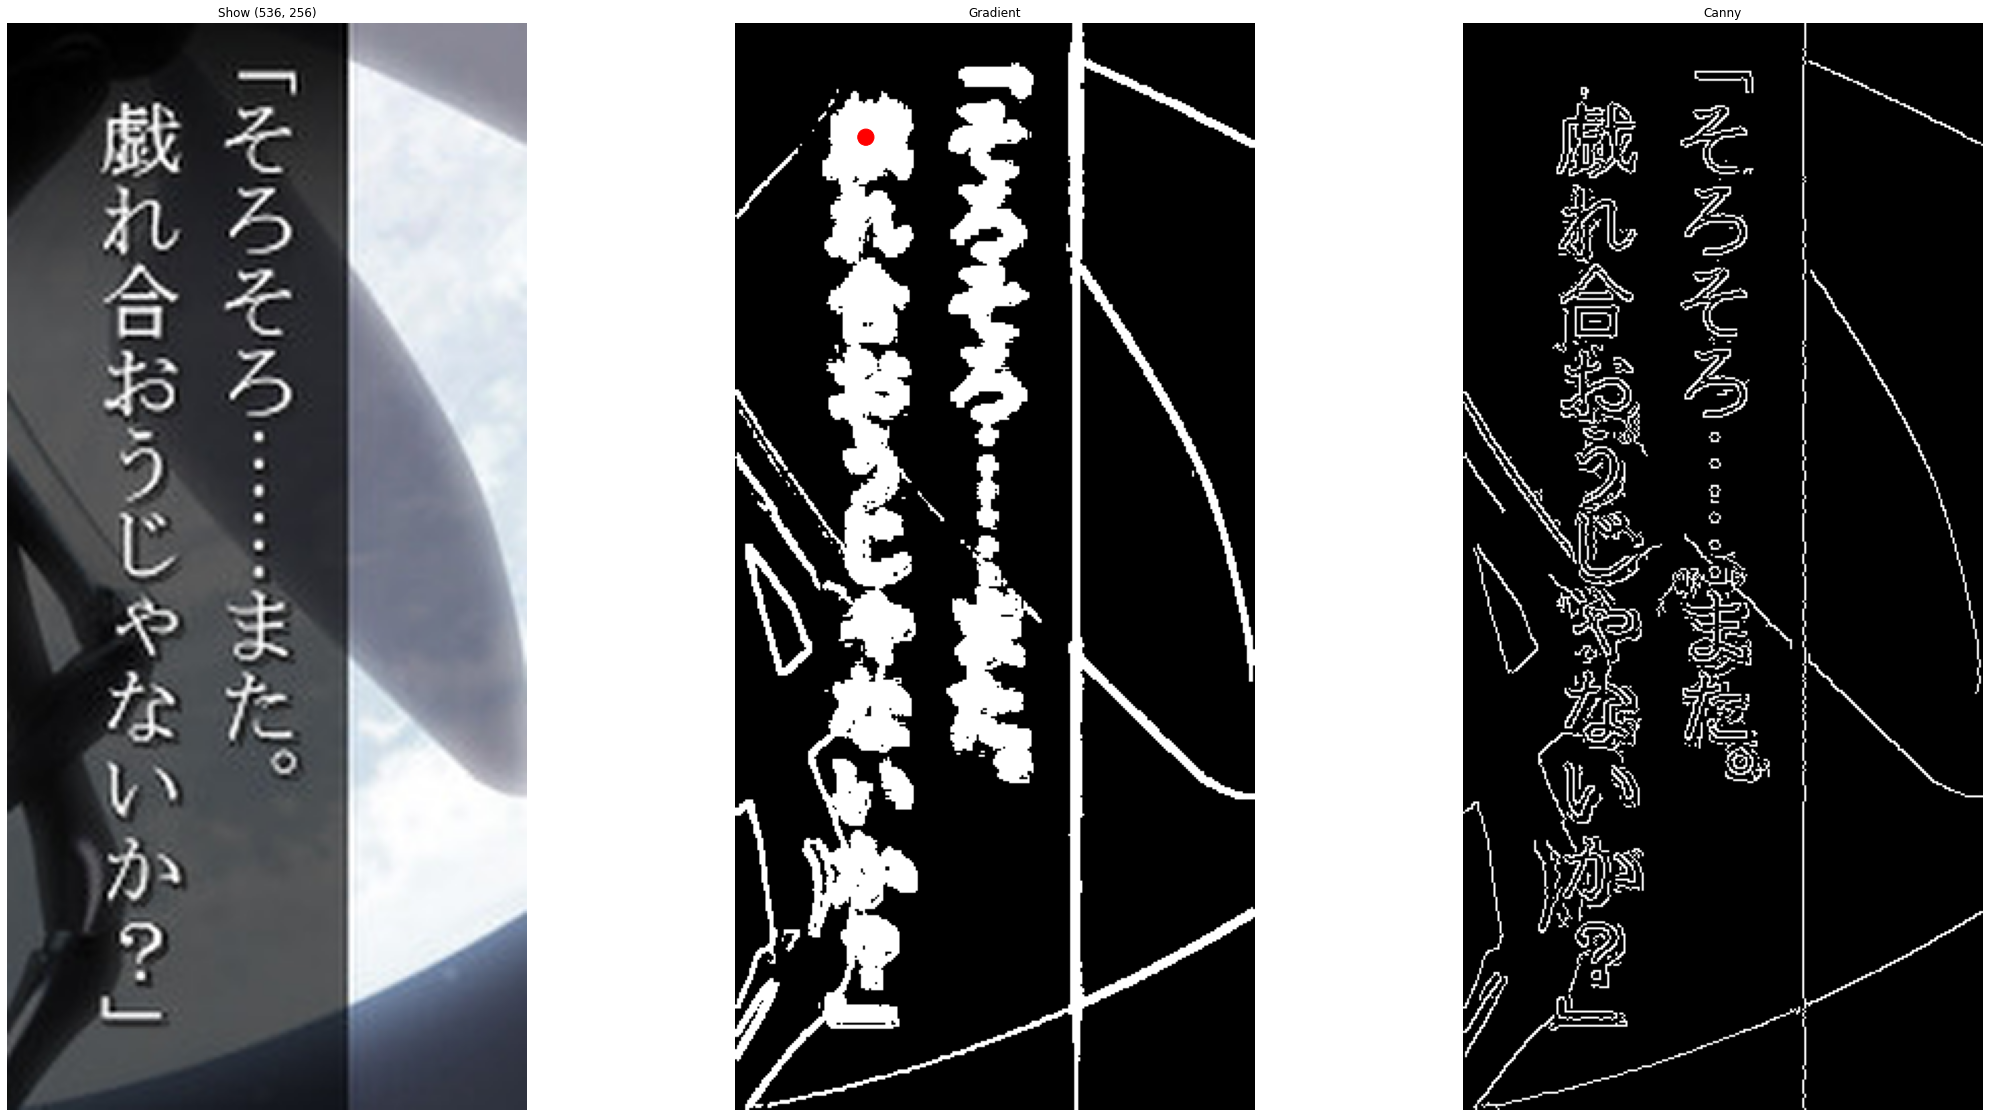


####################
1
VALID [inf, inf, inf, 0]
DISTANCE 5.0
ELEMENT RATIO 3.3333333333333335
ATTEMPT 3.3333333333333335
NEW 3.3333333333333335
TRIGGER 0
ATTEMPT 6.666666666666667
NEW 6.666666666666667
TRIGGER 1
ATTEMPT 7.285714285714286
ATTEMPT 23.0
ATTEMPT 0.3275862068965517
TERMINATED...

####################
2
VALID [inf, inf, inf, 0]
DISTANCE 0.7071067811865476
ELEMENT RATIO 0.9473684210526315
COMPOSITE False
PROBABLE RATIO 0.9473684210526315
INTERCHARACTER SPACING 0
HEIGHT 36
WIDTH 38


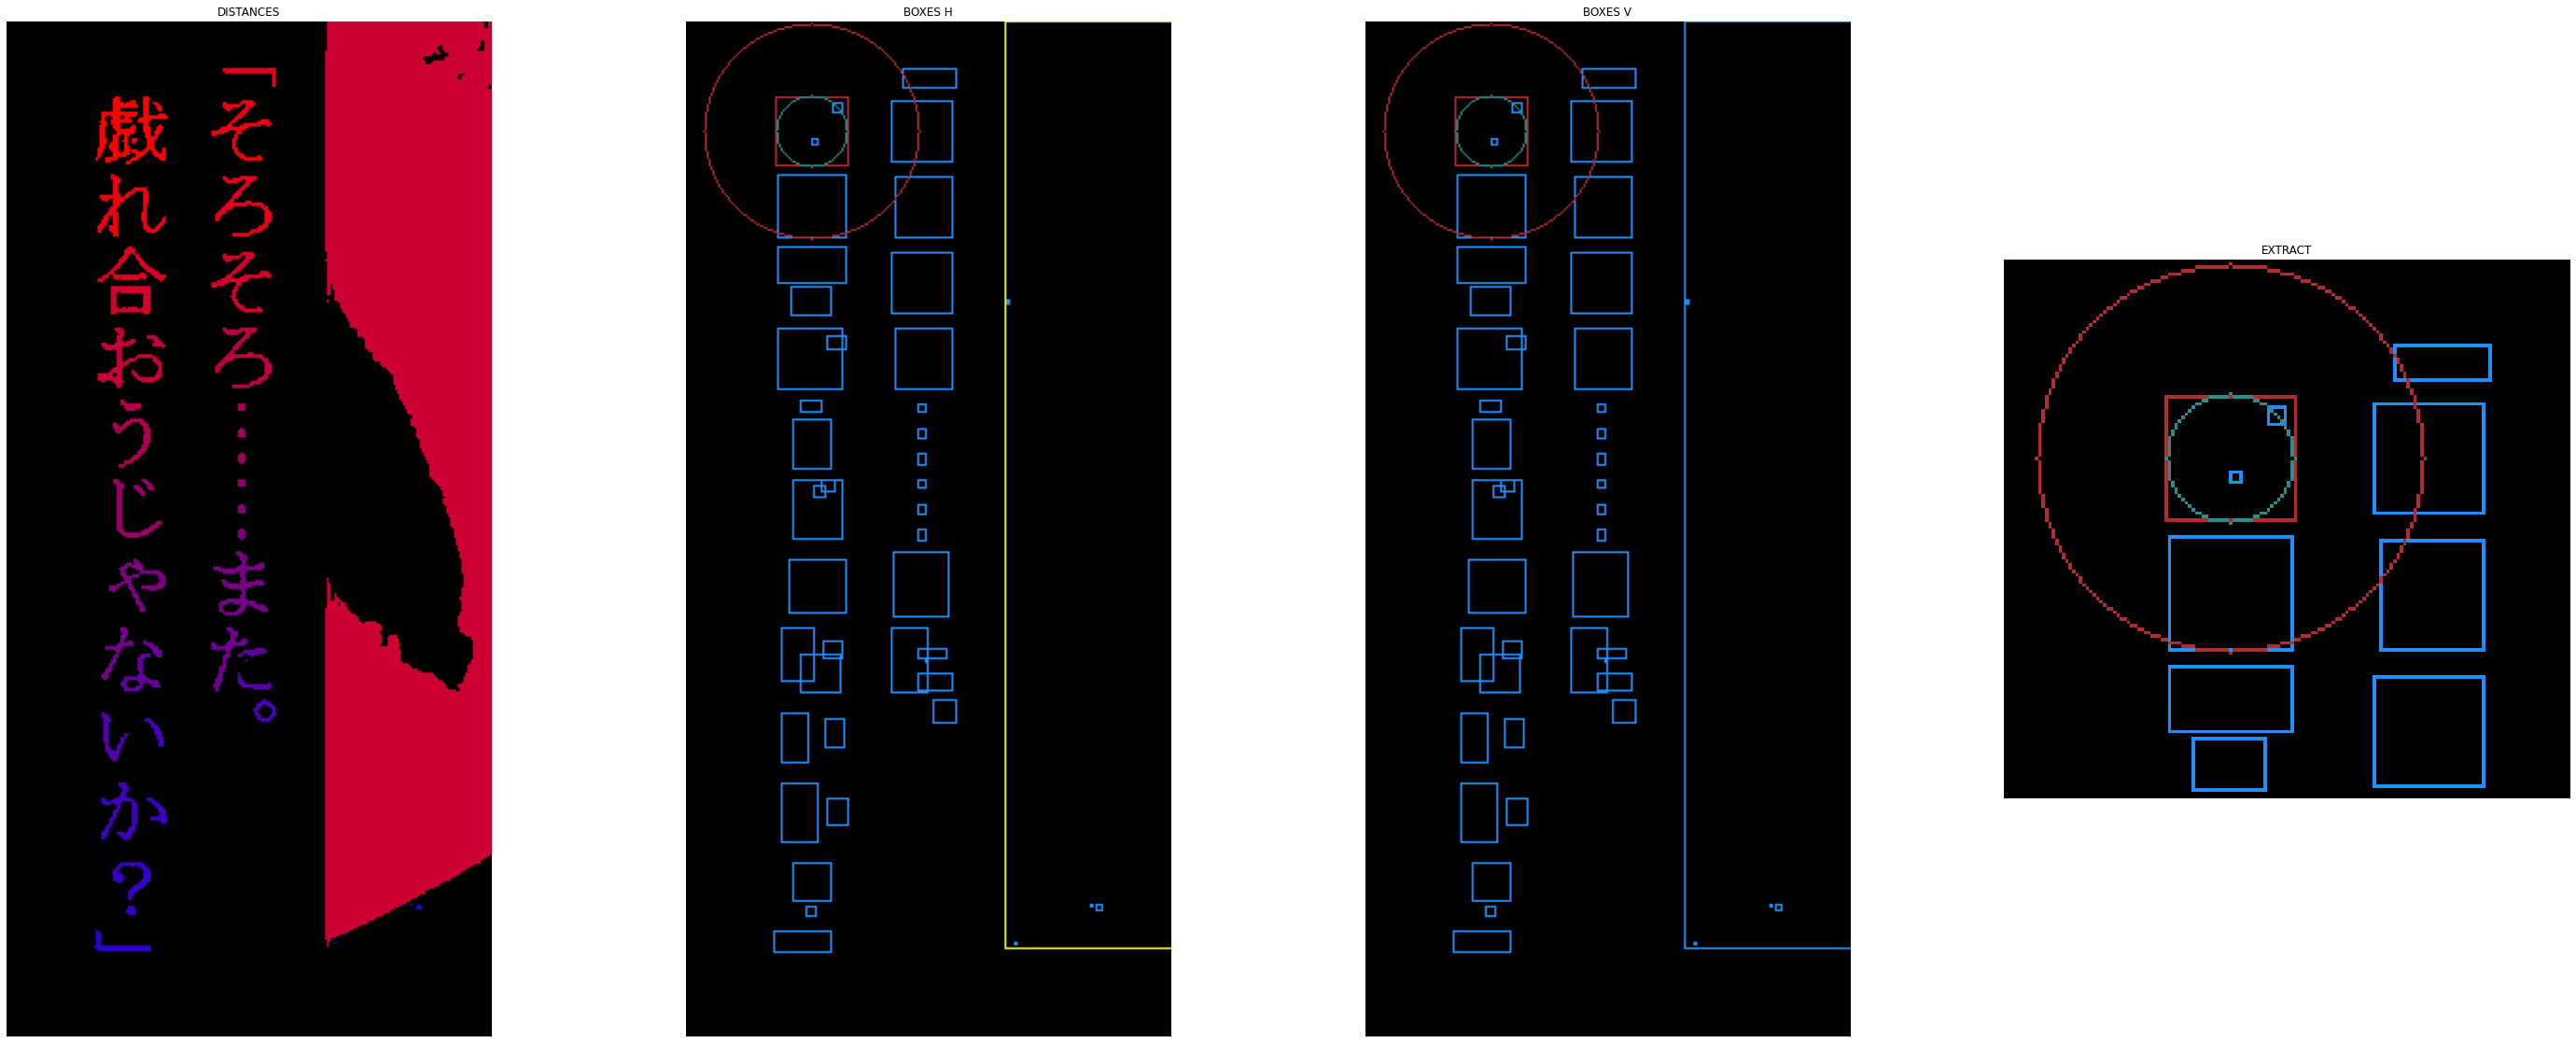

MAX HORIZONTAL SPACING 76
MAX VERTICAL SPACING 72
FLOW DEDUCTION
38 36
(47, 40, 38, 36)
FAILED SPECIAL...
HORIZONTAL SPACING 23.0
VERTICAL SPACING 9.0
FLOW vertical


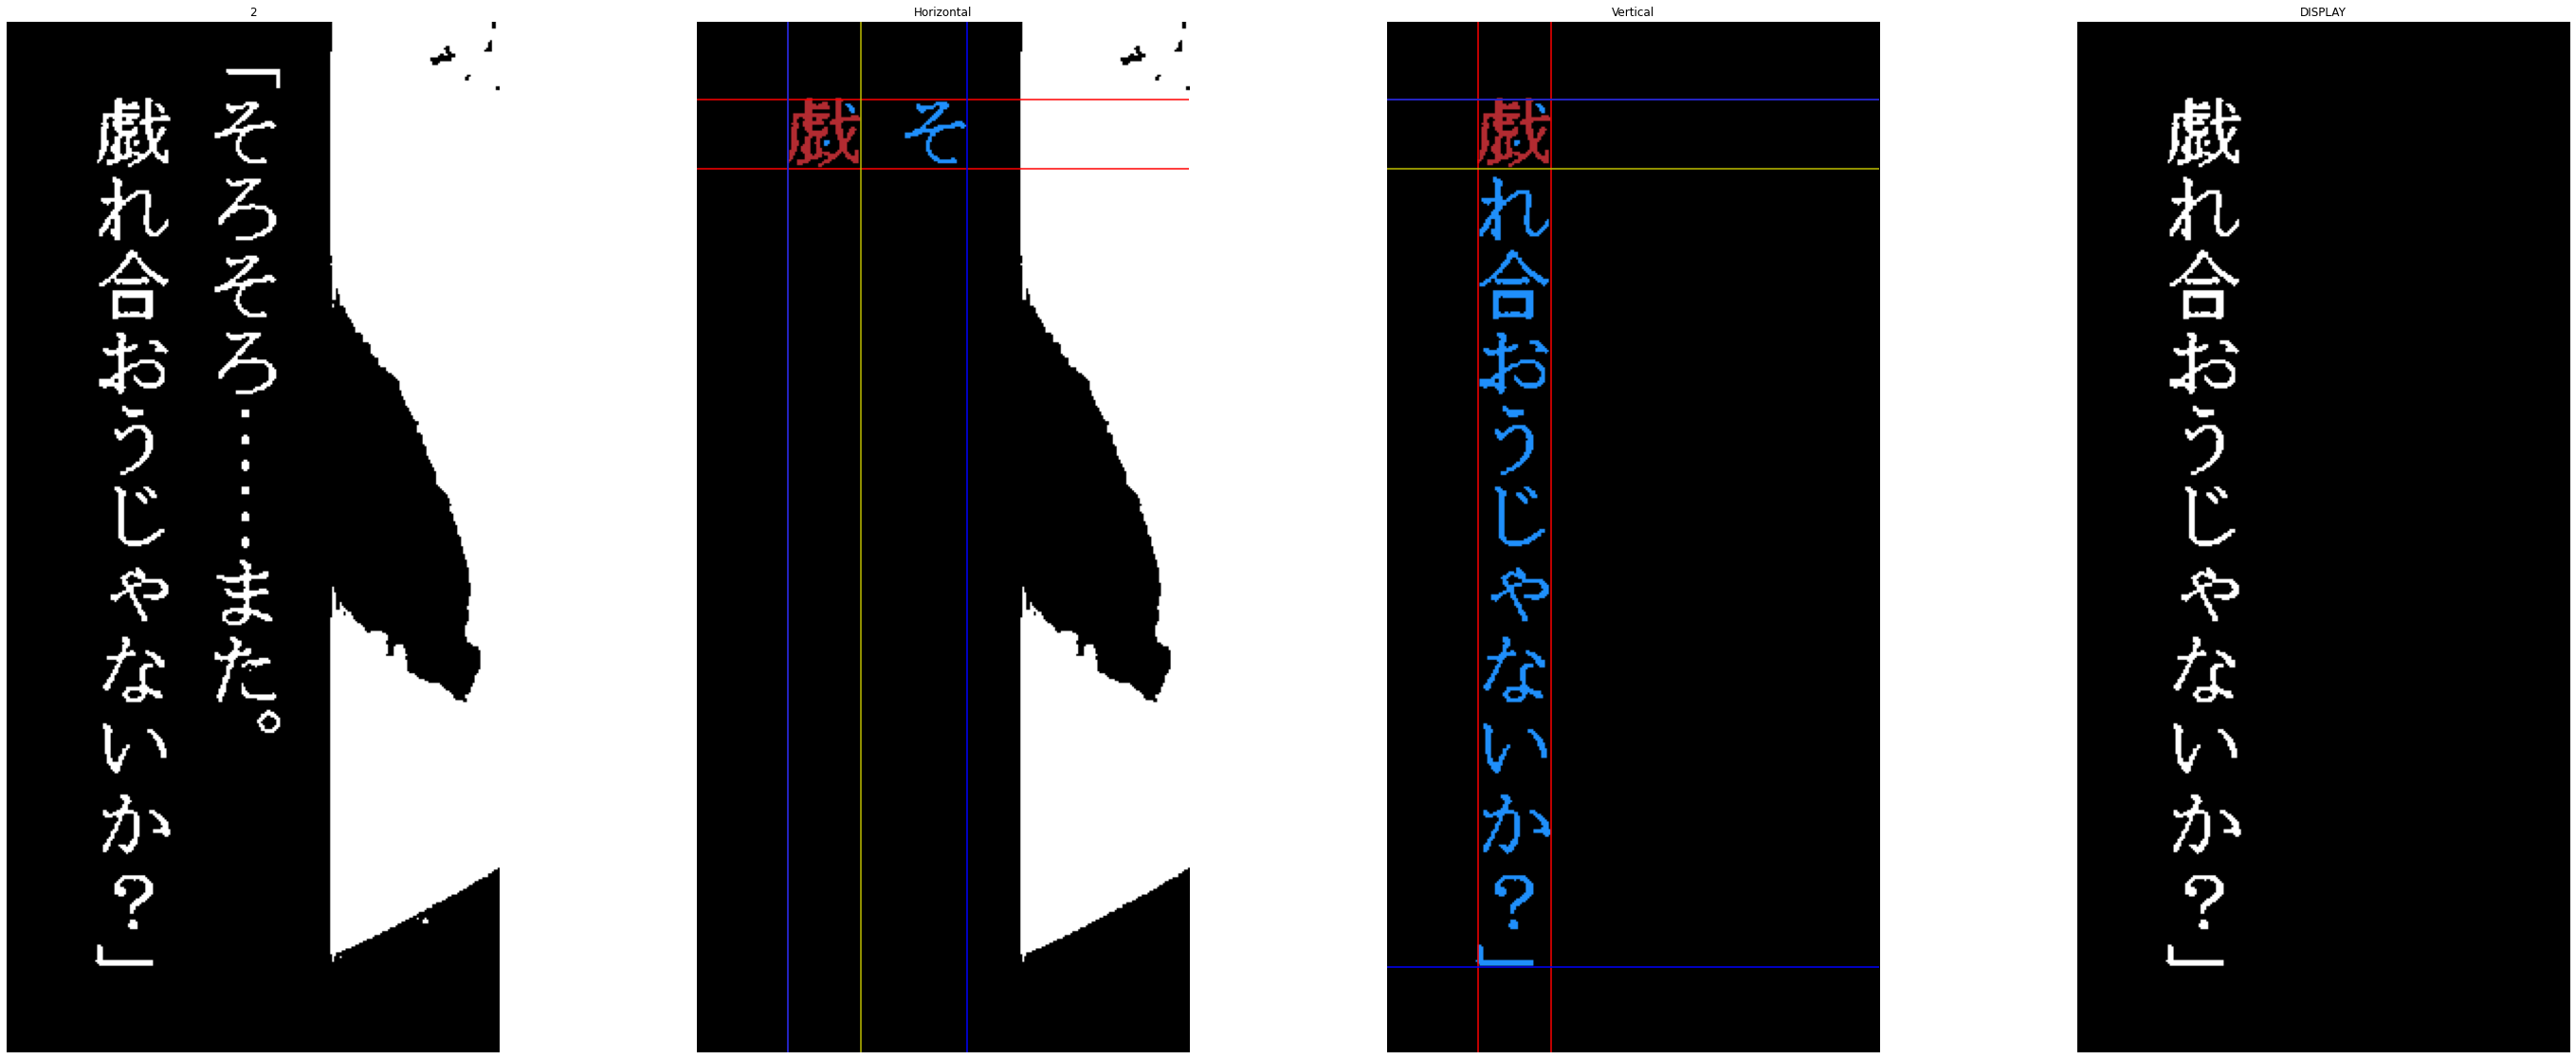

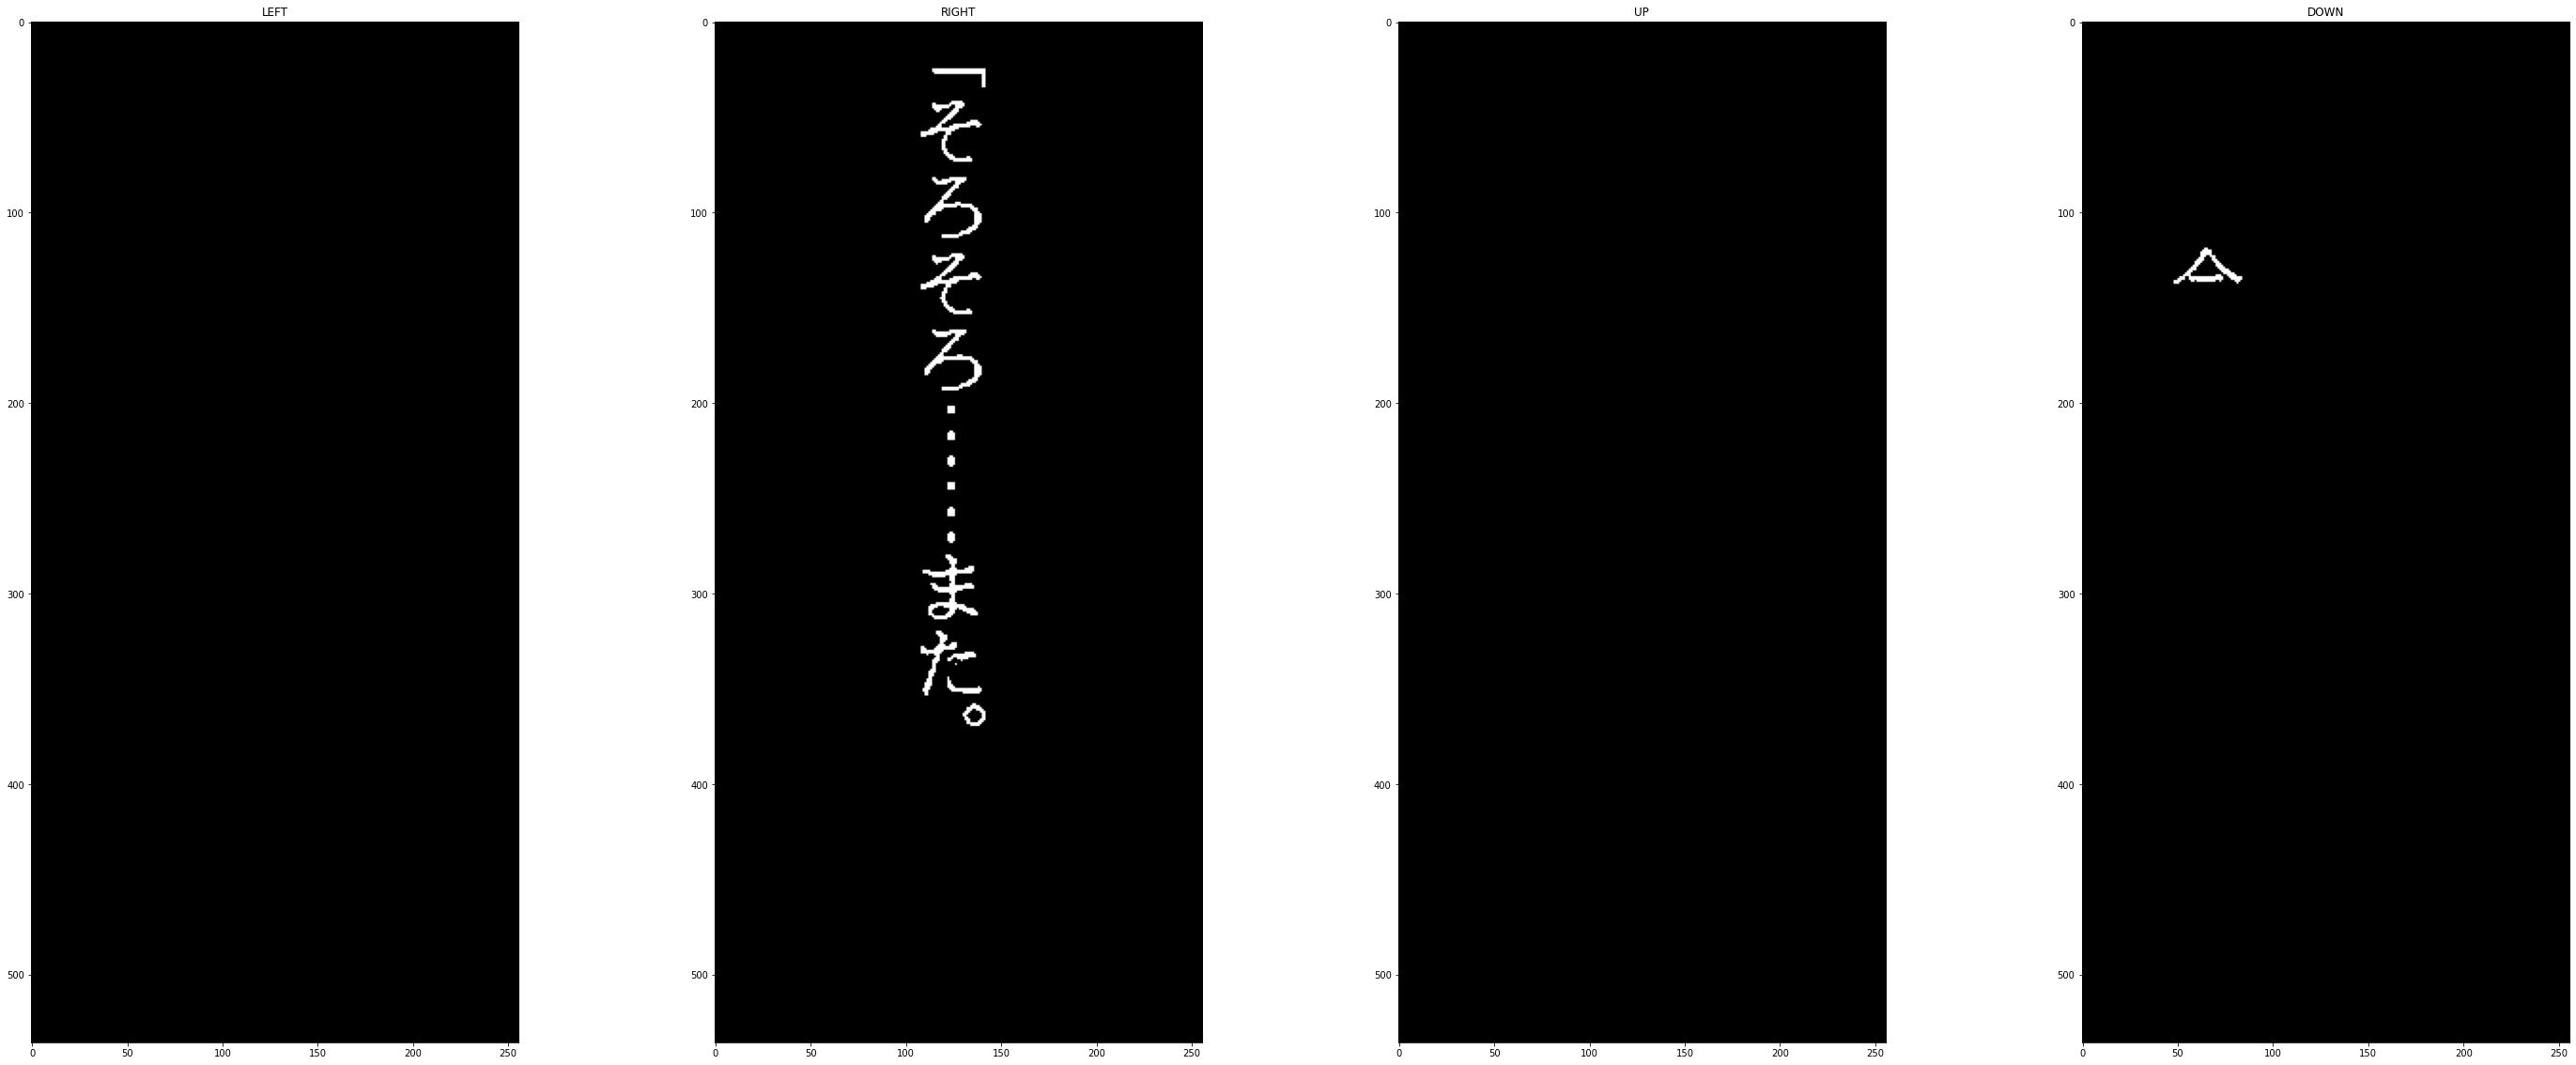

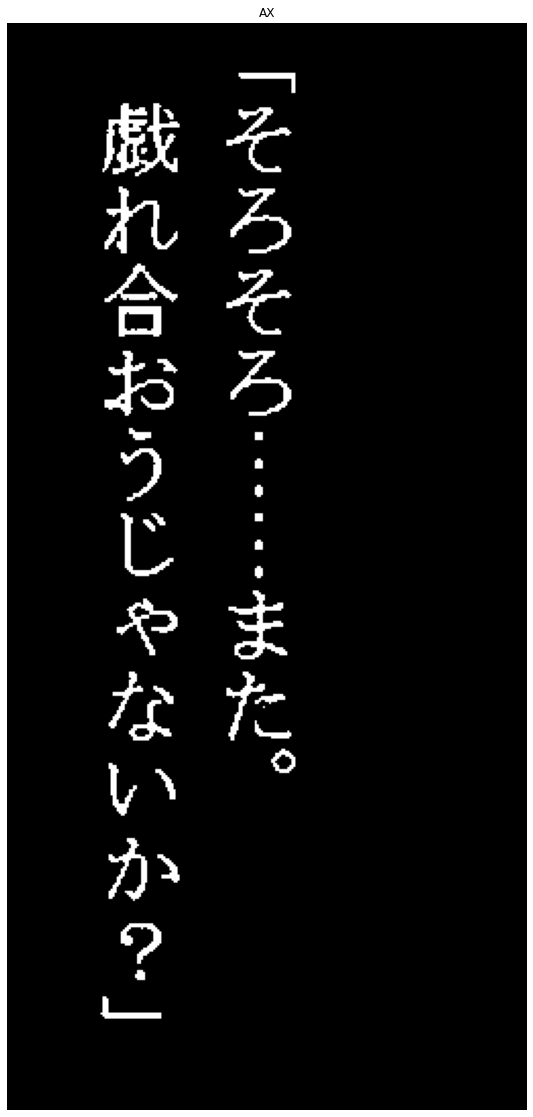

SELECT (56, 192)


WIDTH 38
HEIGHT 2


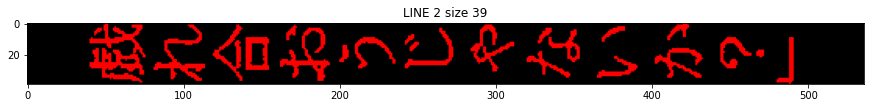

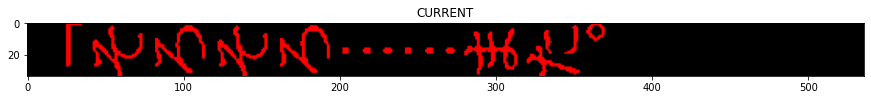

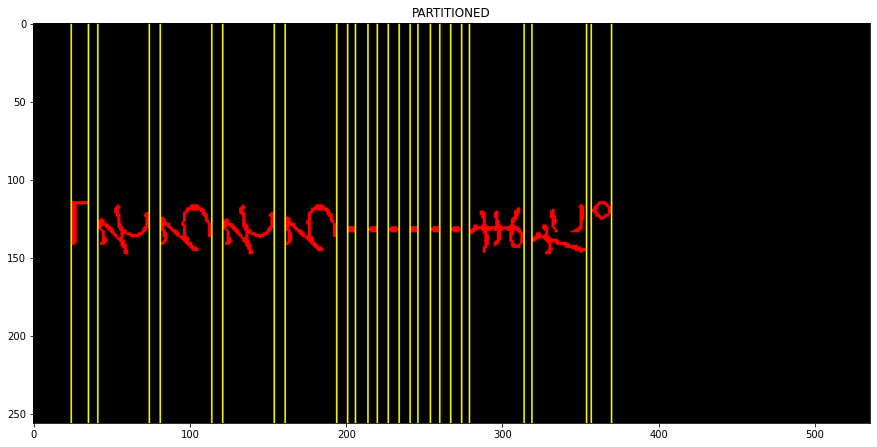

Number of elements:  10
Selected element index:  1
INDEX 5 CHOUON
INDEX 6 CHOUON


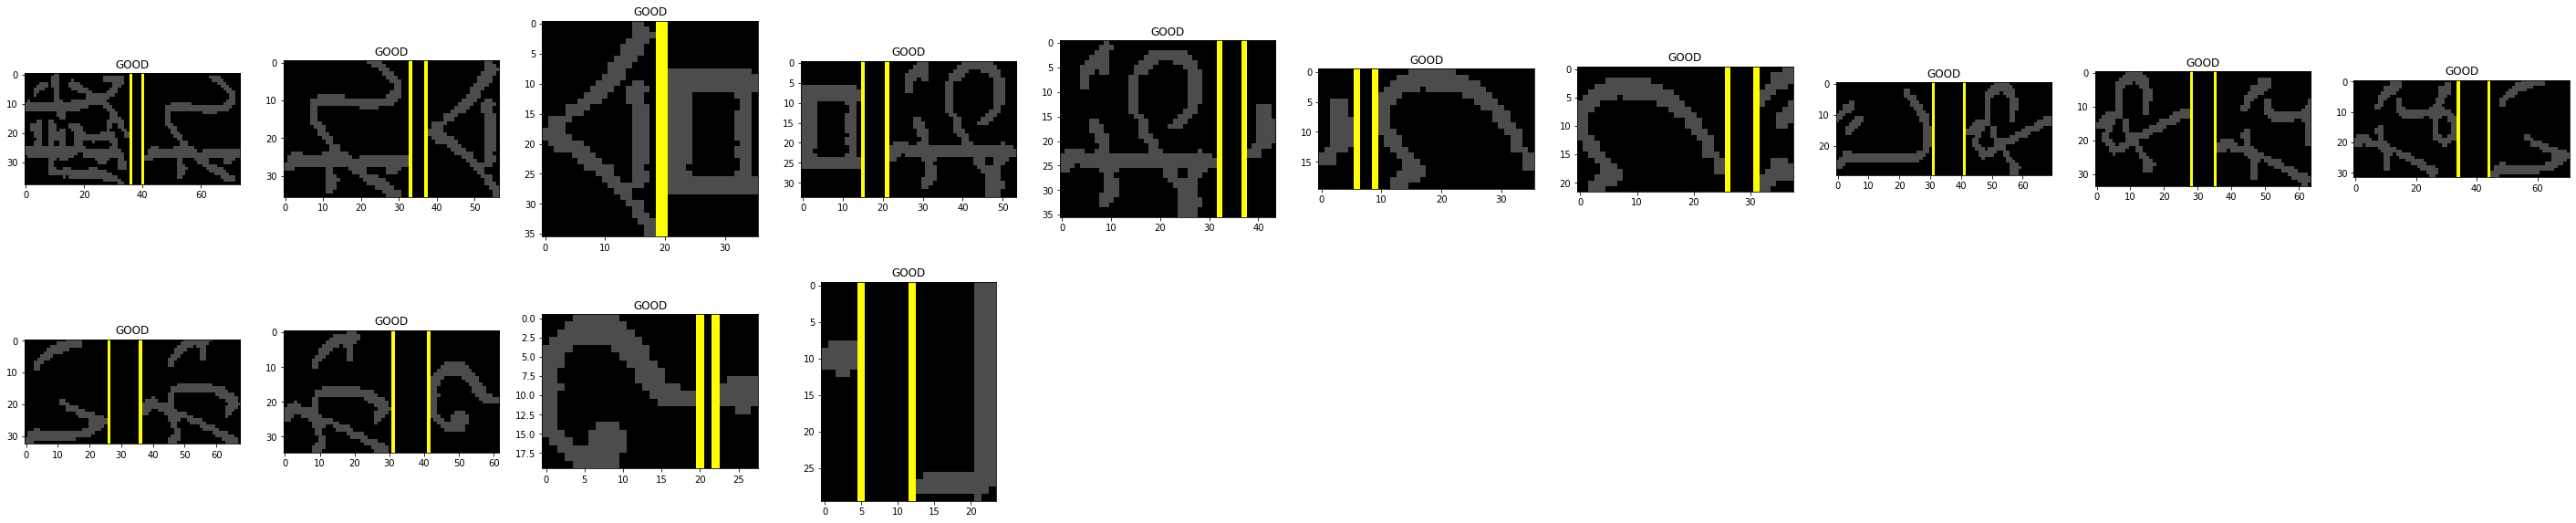

Number of elements:  12
Selected element index:  0


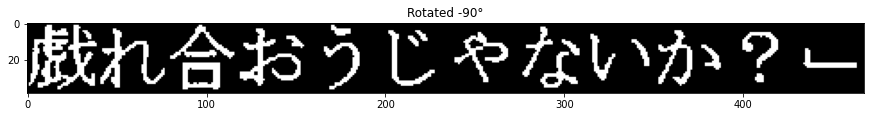

INDEX 5 CHOUON?
INDEX 6 CHOUON?


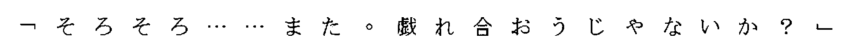

SEGMENTED
[{'literal': 'ド', 'conf': 29}, {'literal': 'ENtMf0', 'conf': 0}]
[{'literal': "「墓~莫即〈孵ロ菫′・(.・ム.・恍蒔\\ね′`誰丿。慶〝亮0'」", 'conf': 37}]
[[{'literal': 'ド', 'conf': 29}, {'literal': 'ENtMf0', 'conf': 0}], [{'literal': "「墓~莫即〈孵ロ菫′・(.・ム.・恍蒔\\ね′`誰丿。慶〝亮0'」", 'conf': 37}]]
CONF 14.5 37.0
MAIN 25.75
QUALITY 0.0
[{'literal': 'ド', 'conf': 29}, {'literal': 'ENtMf0', 'conf': 0}]
[{'literal': "「墓~莫即〈孵ロ菫′・(.・ム.・恍蒔\\ね′`誰丿。慶〝亮0'」", 'conf': 37}]

CEG
ELM [(24, 35, 114, 148, True), (35, 74, 114, 148, True), (74, 114, 114, 148, True), (114, 154, 114, 148, True), (154, 194, 114, 148, True), (201, 234, 114, 148, False), (241, 274, 114, 148, False), (274, 314, 114, 148, True), (314, 354, 114, 148, True), (357, 370, 114, 148, True), (39, 76, 171, 210, True), (76, 114, 171, 210, True), (118, 155, 171, 210, True), (155, 194, 171, 210, True), (199, 236, 171, 210, True), (236, 273, 171, 210, True), (273, 312, 171, 210, True), (312, 354, 171, 210, True), (354, 391, 171, 210, True), (391, 433, 171, 210, True), (

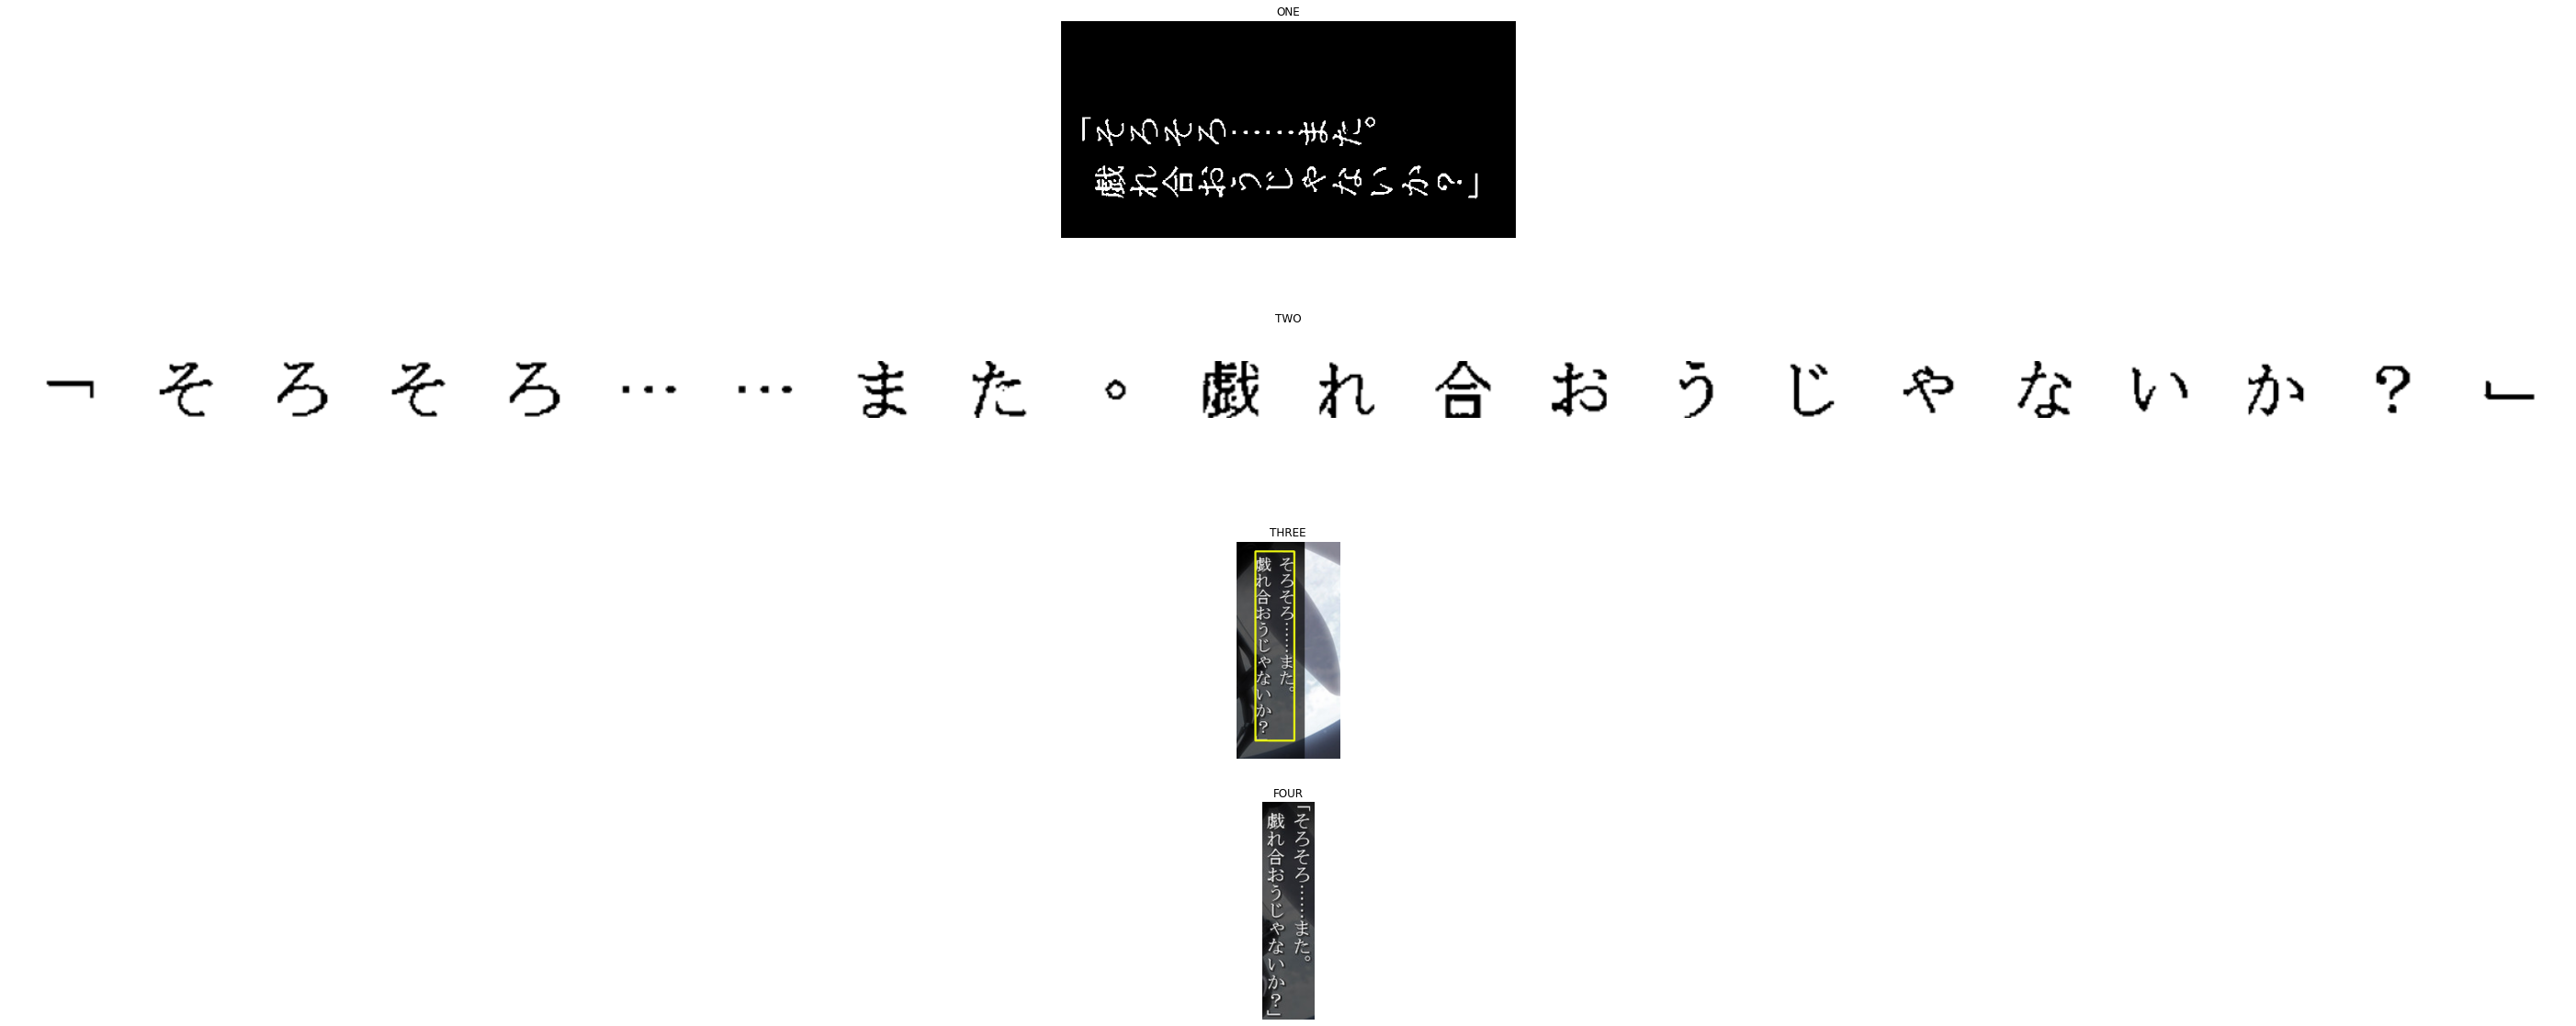

ELM [(24, 35, 114, 148, True), (35, 74, 114, 148, True), (74, 114, 114, 148, True), (114, 154, 114, 148, True), (154, 194, 114, 148, True), (201, 234, 114, 148, False), (241, 274, 114, 148, False), (274, 314, 114, 148, True), (314, 354, 114, 148, True), (357, 370, 114, 148, True), (39, 76, 171, 210, True), (76, 114, 171, 210, True), (118, 155, 171, 210, True), (155, 194, 171, 210, True), (199, 236, 171, 210, True), (236, 273, 171, 210, True), (273, 312, 171, 210, True), (312, 354, 171, 210, True), (354, 391, 171, 210, True), (391, 433, 171, 210, True), (443, 472, 171, 210, True), (479, 491, 171, 210, True)]
[{'literal': '菫宣', 'conf': 80}]
[{'literal': '萱宣', 'conf': 78}]
[[{'literal': '菫宣', 'conf': 80}], [{'literal': '萱宣', 'conf': 78}]]
CONF 80.0 78.0
MAIN 79.0
QUALITY 0.0
[{'literal': '菫宣', 'conf': 80}]
[{'literal': '萱宣', 'conf': 78}]
Continue...
n


########################################
DONE
########################################


In [22]:
#imgselect = 40
#imgselect = 0
#imgselect = 1
#imgselect = 10
#imgselect = 7
#imgselect = 2
#imgselect = 3
#imgselect = 9
#imgselect = 35

imgselect = 50
imgselect = 21

#imgselect = 46
imgselect = 9
imgselect = 53
imgselect = 5
imgselect = 24
imgselect = 54
imgselect = 39
imgselect = 4
imgselect = 18
imgselect = 38
imgselect = 1
imgselect = 2
imgselect = 7
imgselect = 5
imgselect = 56
imgselect = 0
imgselect = 57
imgselect = 30
imgselect = 35
imgselect = 49
imgselect = 47
imgselect = 10

imgselect = 5
manual = True
image = images[imgselect].copy()
if manual:
    select = imagepoint(image,imgselect)[0]
else:
    #select = (62,69)
    select = (470,177)
    #select = tuple(selects[str(imgselect)][0])
print('ORIGINAL SELECT',select)

datapoints = []
forced_dilation = False

b,g,r = image[:,:,0], image[:,:,1], image[:,:,2]
greyscale = True if (b==g).all() and (b==r).all() else False

#if grayscale:
    #image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    #image = cv2.threshold(image,100,255,cv2.THRESH_BINARY)[1]
    #image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
#    pass

print('SIZE',image.shape)
size = list(np.array(image.shape[:2][::-1])*2)
size = tuple(size)
print('SIZE',size)
image_lanc = cv2.resize(image, dsize=size, interpolation=cv2.INTER_LANCZOS4)
print('SELECT',select)
select = tuple(np.array(select)*2)
print('SELECT',select)

image = image_lanc

if greyscale:
    print('IMAGE IS GRAYSCALE')
    improved = extraction(image,select,sharp=True,erode=0)
else:
    improved = extraction(image,select,sharp=False,erode=0)

print()
print()
print("#"*40)
print('DONE')
print("#"*40)

# Remove unwanted contours manually

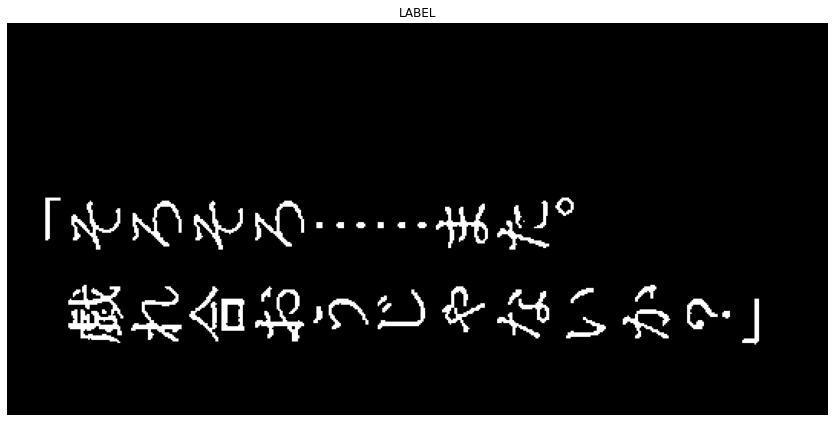

(256, 536)


255

In [23]:
plt.figure(figsize=(50,20))
plt.subplot(131)
plt.title("LABEL")
plt.axis('off')
#img = cv2.cvtColor(save_for_later,cv2.COLOR_GRAY2RGB)
plt.imshow(save_for_later[0],cmap='gray')
#plt.imshow(img,cmap='gray')
plt.show()
print(save_for_later[0].shape)
np.max(save_for_later[0])

In [24]:
#manual = cv2.imread('save_image.png',cv2.IMREAD_GRAYSCALE)
manual = save_for_later[0]
#manual = cv2.bitwise_not(manual)

In [26]:
# remove minor details for demonstration

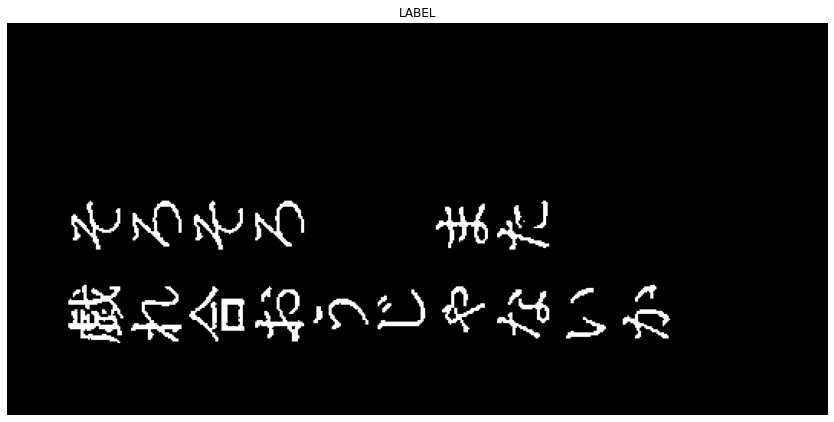

In [25]:
import cv2
import numpy as np

drawing = False
ix,iy = -1,-1

contours, hierarchy = cv2.findContours(manual, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

valid = [i for i in range(0,len(contours))]

removed = []

def draw_rectangle(event,x,y,flags,param):
    #global ix,iy,drawing,mode
    global valid
    global contours
    global removed

    if event == cv2.EVENT_LBUTTONDOWN:
        selected = []
        for i in valid:
            d = cv2.pointPolygonTest(contours[i],(x,y),True)
            if d >= 0.0:
                selected.append((i,d))
                
        selected = sorted(selected,key=lambda x:x[1])
        for m in selected:
            valid.remove(m[0])
            removed.append(m[0])
            break
        

cv2.namedWindow(winname='Manual')
cv2.setMouseCallback('Manual',draw_rectangle)

while True:
    img = np.zeros_like(manual)
    for i in valid:
        if hierarchy[0][i][3] == -1:
            cv2.drawContours(img, contours, i, 255, -1,hierarchy=hierarchy,maxLevel=2)
    cv2.imshow('Manual',img)
    
    key = cv2.waitKey(1)
    if key & 0xFF == 27:
        break
    elif key & 0xFF == ord('u'):
        if removed:
            valid.append(removed.pop())

cv2.destroyAllWindows()

plt.figure(figsize=(50,20))
plt.subplot(131)
plt.title("LABEL")
plt.axis('off')
plt.imshow(img,cmap='gray')
plt.show()

In [ ]:
cv2.destroyAllWindows()

# Other examples

SELECT (56, 192)


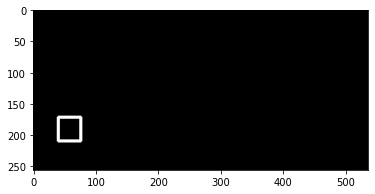

WIDTH 38
HEIGHT 2


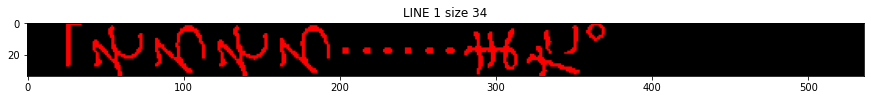

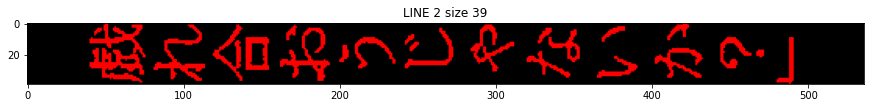

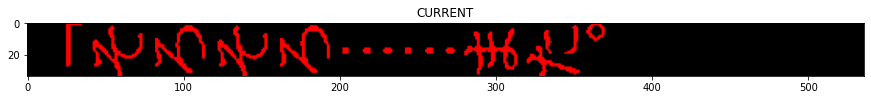

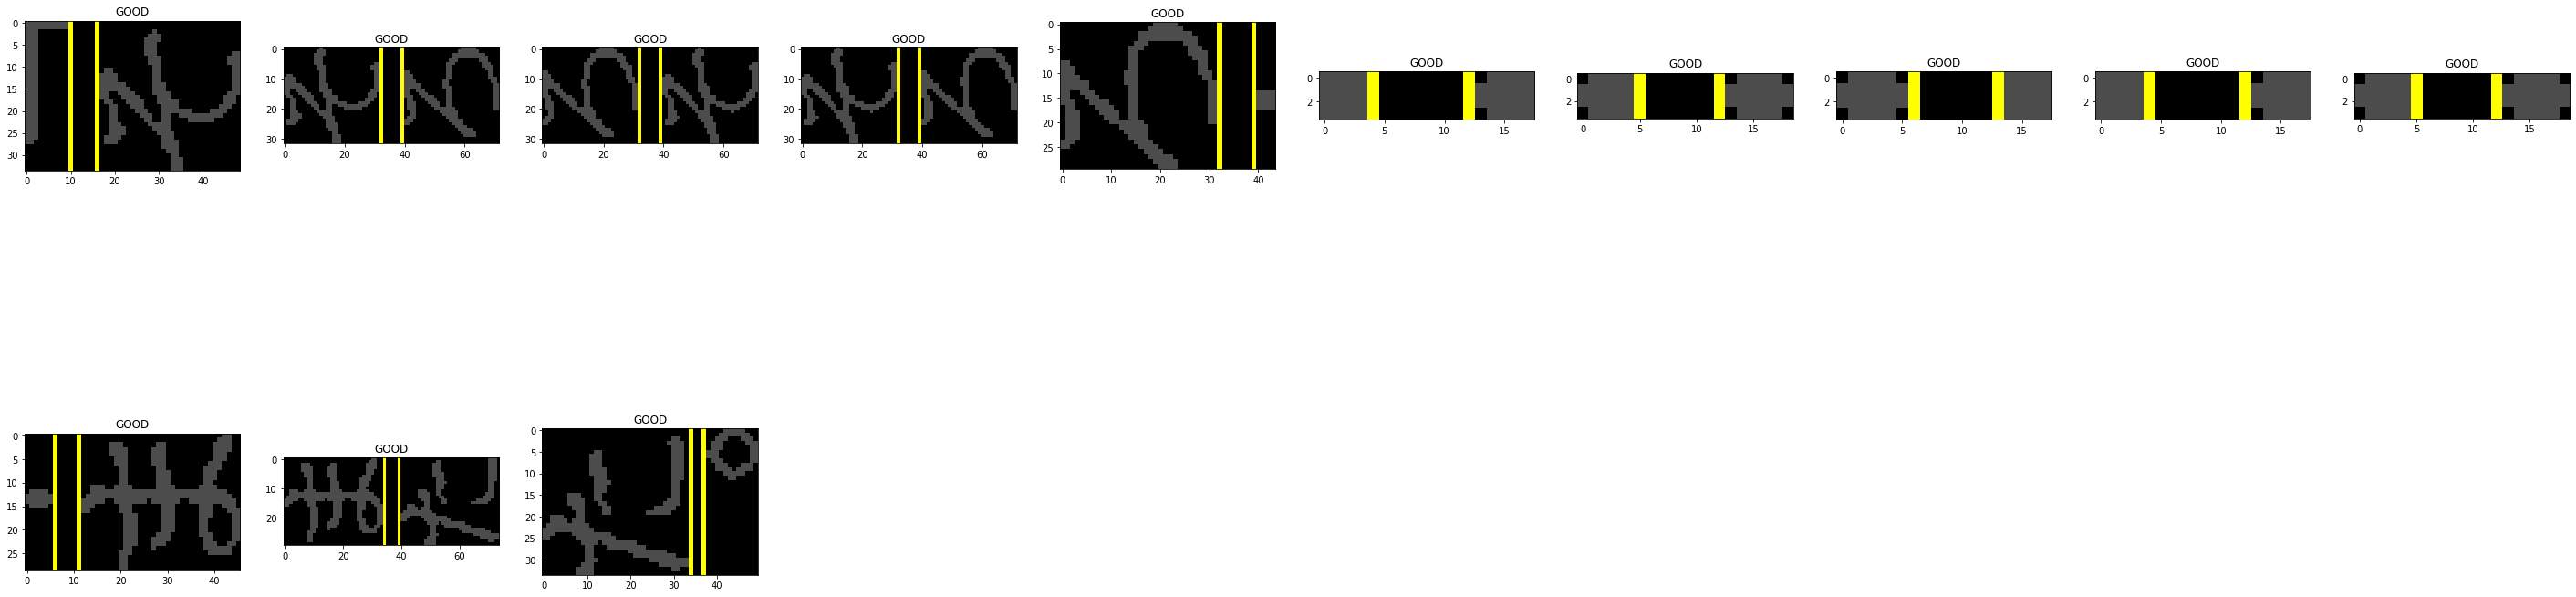

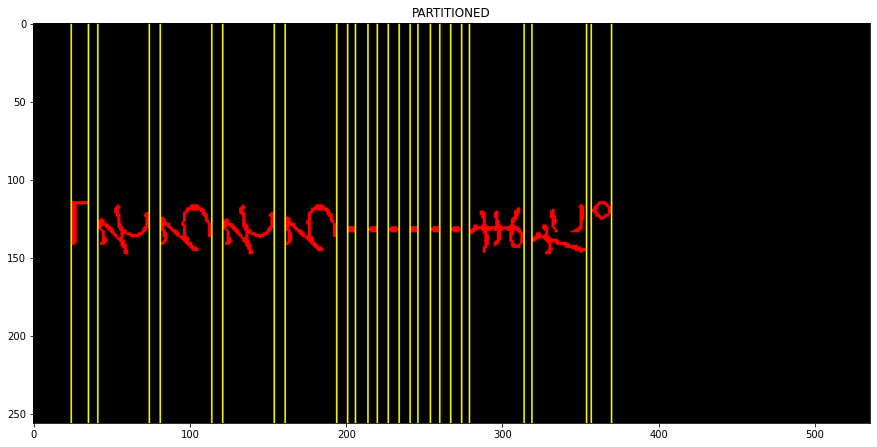

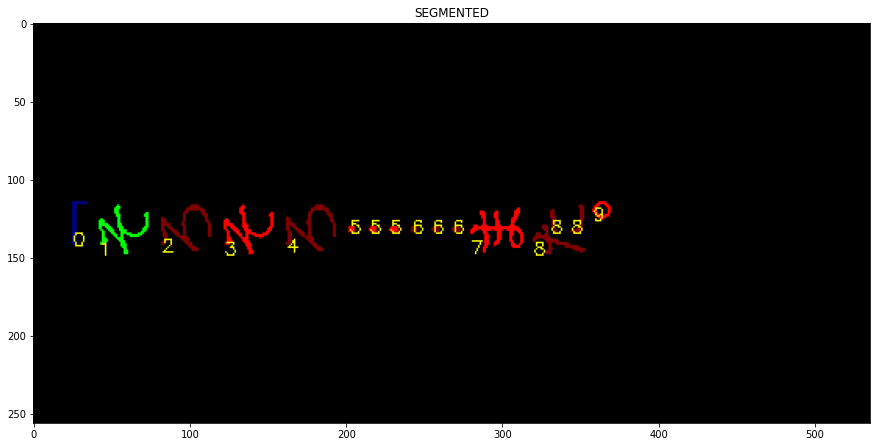

Number of elements:  10
Selected element index:  1
INDEX 5 CHOUON
INDEX 6 CHOUON


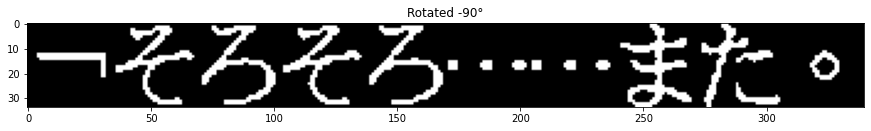

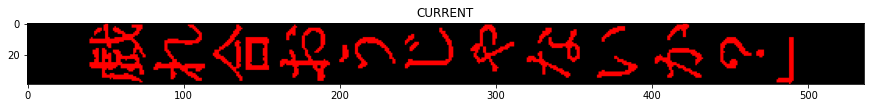

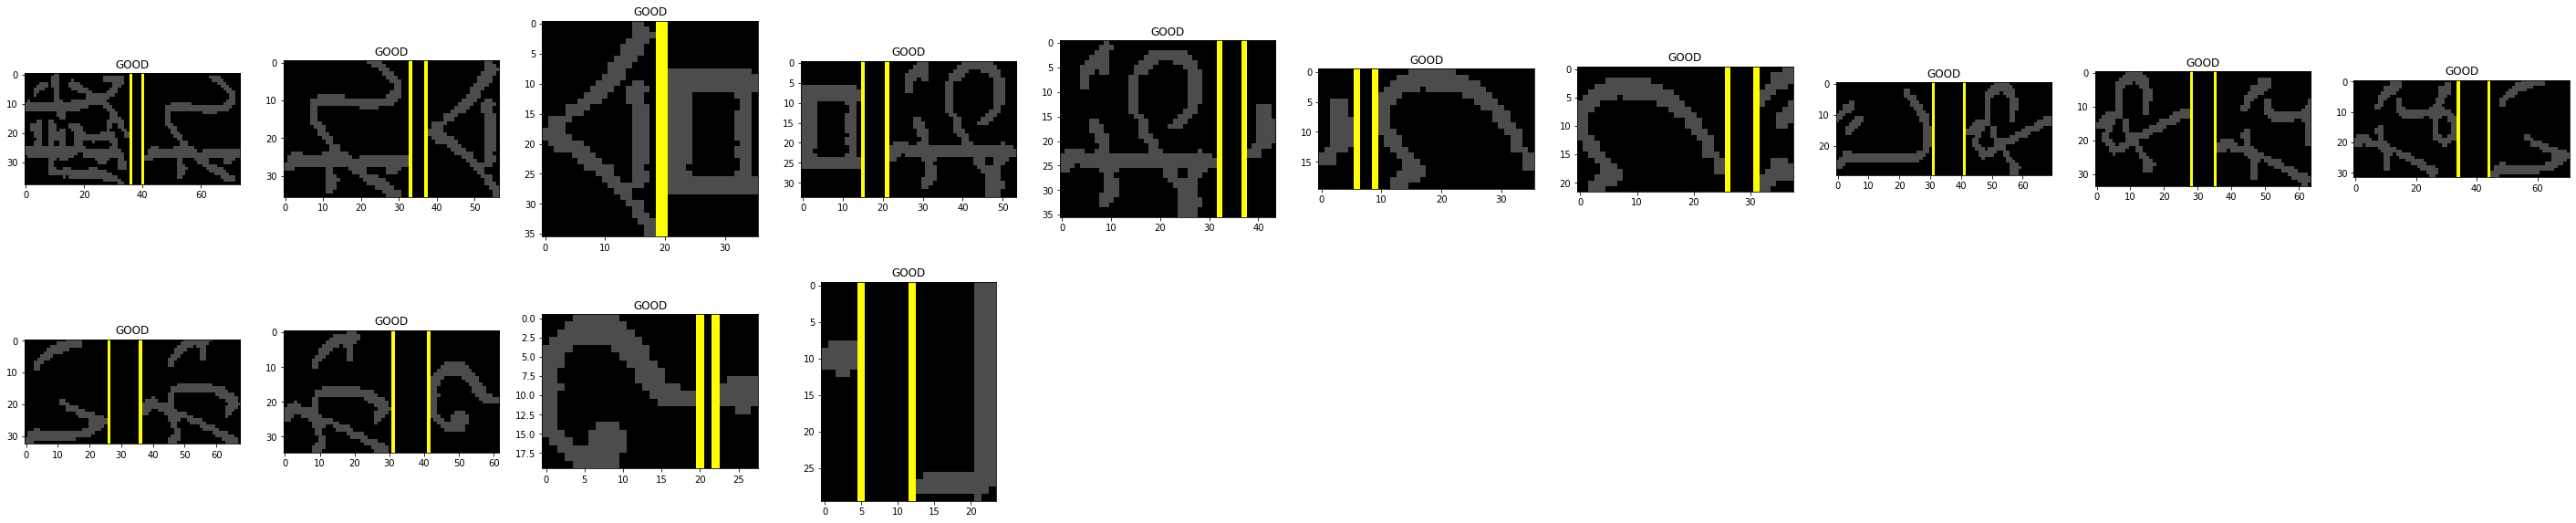

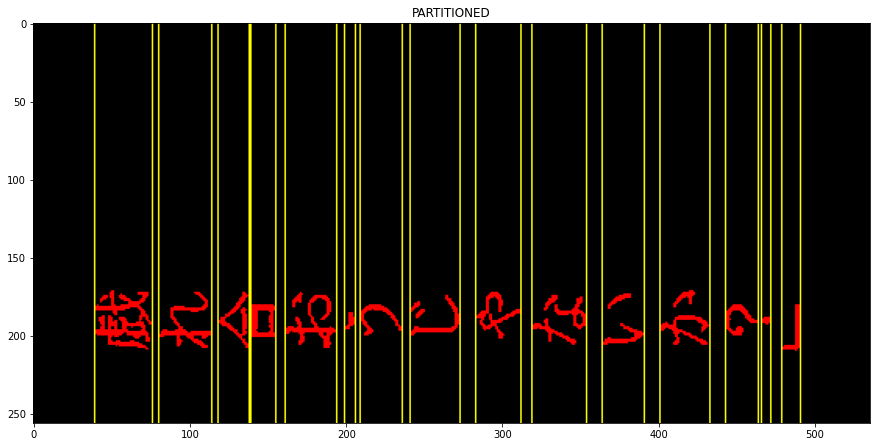

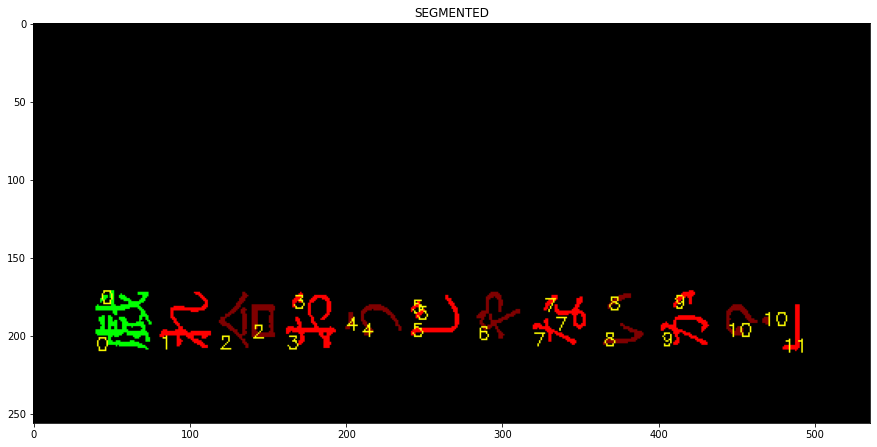

Number of elements:  12
Selected element index:  0


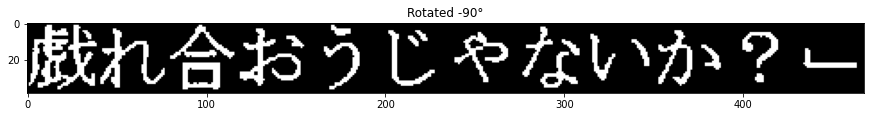

In [27]:
# regenerate the same image for further examples
imagesize, elm, constraints, contours, hierarchy = segment(save_for_later[0],save_for_later[1],5,flow='vertical',single=False)

INDEX 5 CHOUON?
INDEX 6 CHOUON?


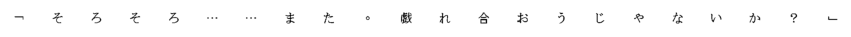

In [28]:
# display the full text with bigger spacing
image = drawCEGimage(imagesize,elm,contours,hierarchy,charspacing=90,padding=30)

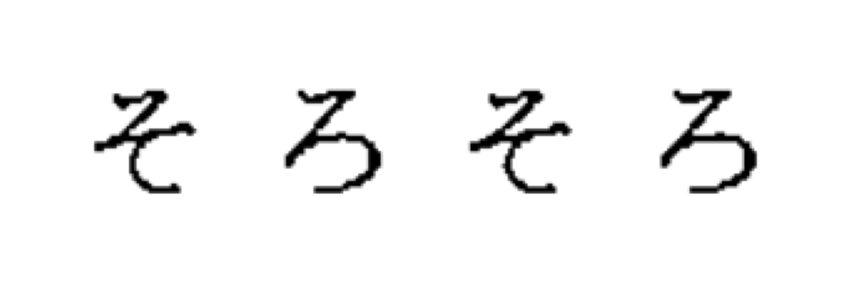

INDEX 0 CHOUON?
INDEX 4 CHOUON?


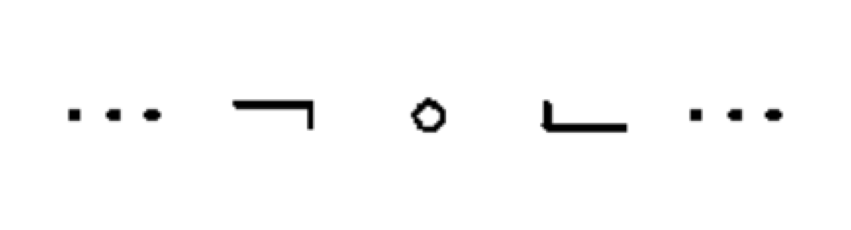

INDEX 5 CHOUON?
INDEX 6 CHOUON?


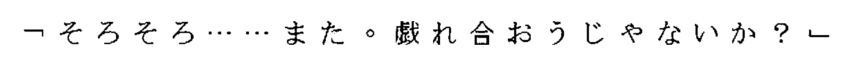

In [29]:
image = drawCEGimage(imagesize,elm[1:5],contours,hierarchy,20,30)
image = drawCEGimage(imagesize,[elm[5],elm[0],elm[9],elm[-1],elm[6]],contours,hierarchy,20,30)
image = drawCEGimage(imagesize,elm,contours,hierarchy,20,30)

In [30]:
returnCEGindex(elm,save_for_later[1]) # figure out which character was selected

10

[[ 6.12323400e-17 -1.00000000e+00  9.60000000e+01]
 [ 1.00000000e+00  6.12323400e-17 -7.10542736e-15]]
Rescale 1x
(96, 96, 3)


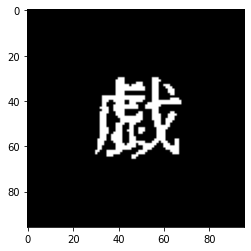

In [36]:
empty = generateSingleChar(returnCEGindex(elm,save_for_later[1]),imagesize,elm,contours,hierarchy) # draw it

In [32]:
import pandas as pd
from tensorflow import keras
import gc
from tensorflow.keras.models import load_model
#self.lookup = pd.read_json('../4clookup.json') # created in the OCR file under the section 'CNN prep'
keras.backend.clear_session()
gc.collect()

0

In [33]:
# The four corner estimator
class FourCorner(object):
    
    def __init__(self):
        import pandas as pd
        from tensorflow import keras
        import gc
        from tensorflow.keras.models import load_model
        self.lookup = pd.read_json('../../4clookup.json') # created in the OCR file under the section 'CNN prep'
        keras.backend.clear_session()
        gc.collect()

        self.modelA = load_model('../../4cA.h5')
        self.modelB = load_model('../../4cB.h5')
        self.modelC = load_model('../../4cC.h5')
        self.modelD = load_model('../../4cD.h5')
        
    def estimate(self,empty):
        percent = self.modelA.predict(empty.reshape(1,96,96,3))
        print('A',percent)
        key = percent.argmax(axis=-1)[0]
        print('A',key)
        A = self.lookup[self.lookup['4cA'] == key]
        res = A['literal'].to_string(index=False)
        A = [x.strip() for x in res.splitlines()]
        
        percent = self.modelB.predict(empty.reshape(1,96,96,3))
        print('B',percent)
        key = percent.argmax(axis=-1)[0]
        print('B',key)
        B = self.lookup[self.lookup['4cB'] == key]
        res = B['literal'].to_string(index=False)
        B = [x.strip() for x in res.splitlines()]
        
        percent = self.modelC.predict(empty.reshape(1,96,96,3))
        print('C',percent)
        key = percent.argmax(axis=-1)[0]
        print('C',key)
        C = self.lookup[self.lookup['4cC'] == key]
        res = C['literal'].to_string(index=False)
        C = [x.strip() for x in res.splitlines()]
        
        percent = self.modelD.predict(empty.reshape(1,96,96,3))
        print('D',percent)
        key = percent.argmax(axis=-1)[0]
        print('D',key)
        D = self.lookup[self.lookup['4cD'] == key]
        res = D['literal'].to_string(index=False)
        D = [x.strip() for x in res.splitlines()]
        
        
        return np.unique(np.array([A+B+C+D]),return_counts=True)

In [34]:
estimator = FourCorner()

In [37]:
items = estimator.estimate(empty)

A [[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]]
A 2
B [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
B 7
C [[0.0000000e+00 1.0000000e+00 6.5638434e-23 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]
C 1
D [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
D 0


In [38]:
import jishox
db = jishox.Database()

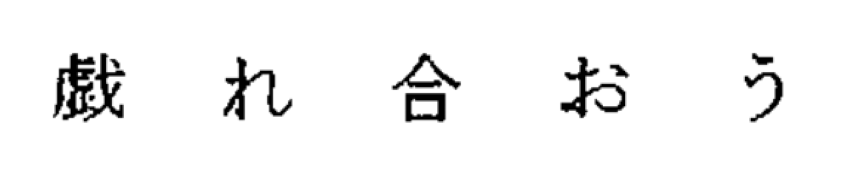

[{'literal': '戯', 'conf': 75}, {'literal': 'れ', 'conf': 76}, {'literal': '合', 'conf': 78}, {'literal': 'お', 'conf': 85}, {'literal': 'う', 'conf': 88}]
[{'literal': '戮', 'conf': 71}, {'literal': 'れ', 'conf': 75}, {'literal': '合', 'conf': 75}, {'literal': 'お', 'conf': 76}, {'literal': 'う', 'conf': 28}]


In [43]:
#image = drawCEGimage(imagesize,[elm[0],elm[1],elm[3],elm[4]],contours,hierarchy,10,30)
image = drawCEGimage(imagesize,elm[10:15],contours,hierarchy,50,30)
cv2.imwrite('save_image.png',cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
datapoints = call_tesseract(elm,T=[7,13])

In [47]:
string = ''.join([x['literal'] for x in datapoints[0]])
text = jishox.Text(string)
text.view

{0: ('戯れ合おう', '戯れ合う')}

In [52]:
# as the confidence isn't that high we continue as so

# create the dictionary form of the word in question
attempt = str(text.words[0].dict).replace(datapoints[0][0]['literal'],'〇') # we replace the unknown character with 〇
print(attempt)
info = db.guess(attempt,len(attempt)) # we obtain all possible words
info

〇れ合う


[('お', 'おれ合う'),
 ('す', 'すれ合う'),
 ('な', 'なれ合う'),
 ('戯', '戯れ合う'),
 ('折', '折れ合う'),
 ('摩', '摩れ合う'),
 ('擦', '擦れ合う'),
 ('縺', '縺れ合う'),
 ('触', '触れ合う'),
 ('馴', '馴れ合う')]

In [54]:
import pandas as pd
lookup = pd.read_json('../../4clookup.json') # created in the OCR file under the section 'CNN prep'

In [55]:
possible = [x[0] for x in info if not jishox.kana_support.isKANA(x[0])] # remove kana as it can't be checked via CNNs
possible

['戯', '折', '摩', '擦', '縺', '触', '馴']

In [56]:
lookup[lookup['literal'] == '戯']

literal  4cA  4cB  4cC  4cD
495       戯    2    3    2    5

In [59]:
valid = set(possible).intersection(set(items[0])) # we narrowed down our selection
valid

{'戯', '縺', '触', '馴'}

In [60]:
datapoints[0][0]['literal'] in valid # test if the symbol in question is present in the set

True

INDEX 5 CHOUON?
INDEX 6 CHOUON?


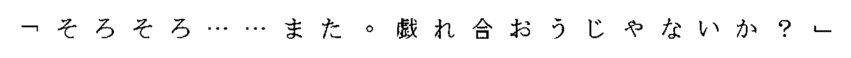

True

In [68]:
#image = drawCEGimage(imagesize,[elm[0],elm[1],elm[3],elm[4]],contours,hierarchy,10,30)
image = drawCEGimage(imagesize,elm,contours,hierarchy,30,30)
cv2.imwrite('save_image.png',cv2.cvtColor(image,cv2.COLOR_RGB2BGR))

## Align both transcripts

{'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '8': [], '9': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': [], '16': [], '17': [], '18': [], '19': [], '20': [], '21': []}
[{'literal': 'っ', 'conf': 88}, {'literal': 'そ', 'conf': 83}, {'literal': 'ろ', 'conf': 83}, {'literal': 'そ', 'conf': 78}, {'literal': 'ろ', 'conf': 72}, {'literal': '一', 'conf': 53}, {'literal': '一', 'conf': 33}, {'literal': '一', 'conf': 60}, {'literal': 'ま', 'conf': 78}, {'literal': '。', 'conf': 13}, {'literal': 'た', 'conf': 13}, {'literal': 'e', 'conf': 30}, {'literal': '戯', 'conf': 11}, {'literal': 'れ', 'conf': 11}, {'literal': '合', 'conf': 70}, {'literal': 'お', 'conf': 95}, {'literal': ')', 'conf': 46}, {'literal': 'う', 'conf': 63}, {'literal': 'じ', 'conf': 59}, {'literal': 'や', 'conf': 61}, {'literal': 'ー', 'conf': 42}, {'literal': 'な', 'conf': 66}, {'literal': 'い', 'conf': 83}, {'literal': 'か', 'conf': 81}, {'literal': '?', 'conf': 55}, {'literal': 'ー', 'conf': 89}]
[{'liter

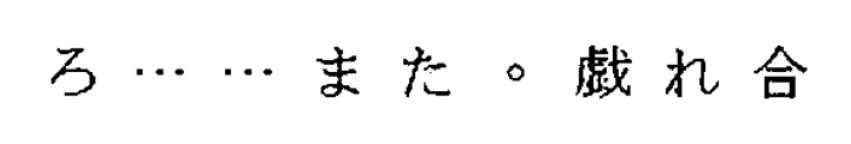

[{'literal': 'ろ', 'conf': 94}, {'literal': '…', 'conf': 70}, {'literal': '…', 'conf': 85}, {'literal': 'ま', 'conf': 91}, {'literal': 'た', 'conf': 90}, {'literal': '。', 'conf': 13}, {'literal': '戯', 'conf': 48}, {'literal': 'れ', 'conf': 95}, {'literal': '合', 'conf': 94}]
[{'literal': 'ろ', 'conf': 81}, {'literal': 'ー', 'conf': 64}, {'literal': 'ー', 'conf': 55}, {'literal': 'ま', 'conf': 86}, {'literal': 'た', 'conf': 86}, {'literal': 'e', 'conf': 47}, {'literal': '戮', 'conf': 48}, {'literal': 'れ', 'conf': 94}, {'literal': '合', 'conf': 69}]
{'0': [{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}], '1': [{'literal': 'そ', 'conf': 83}, {'literal': 'そ', 'conf': 87}], '2': [{'literal': 'ろ', 'conf': 83}, {'literal': 'ろ', 'conf': 81}], '3': [{'literal': 'そ', 'conf': 78}, {'literal': 'そ', 'conf': 90}], '4': [{'literal': 'ろ', 'conf': 72}, {'literal': 'ろ', 'conf': 15}, {'literal': 'ろ', 'conf': 94}, {'literal': 'ろ', 'conf': 94}], '5': [{'literal': '…', 'conf': 70}, {'literal': '…', 'conf': 7

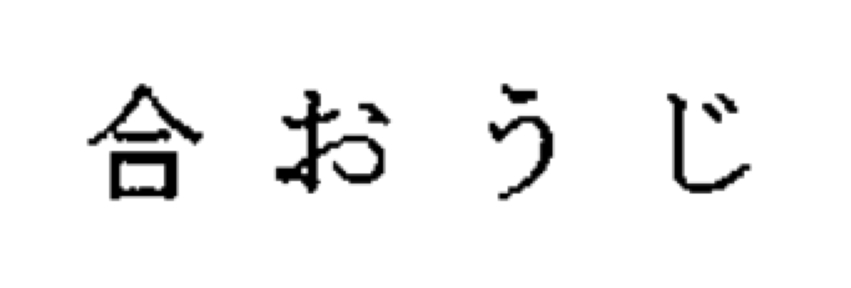

[{'literal': '合', 'conf': 96}, {'literal': 'お', 'conf': 95}, {'literal': 'う', 'conf': 95}, {'literal': 'じ', 'conf': 95}]
[{'literal': '合', 'conf': 83}, {'literal': 'お', 'conf': 92}, {'literal': 'う', 'conf': 90}, {'literal': 'ビ', 'conf': 73}]
合おうじ
合おうビ
Match(a=0, b=0, size=3)
3
{'0': [{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}], '1': [{'literal': 'そ', 'conf': 83}, {'literal': 'そ', 'conf': 87}], '2': [{'literal': 'ろ', 'conf': 83}, {'literal': 'ろ', 'conf': 81}], '3': [{'literal': 'そ', 'conf': 78}, {'literal': 'そ', 'conf': 90}], '4': [{'literal': 'ろ', 'conf': 72}, {'literal': 'ろ', 'conf': 15}, {'literal': 'ろ', 'conf': 94}, {'literal': 'ろ', 'conf': 94}], '5': [{'literal': '…', 'conf': 70}, {'literal': '…', 'conf': 70}], '6': [{'literal': '…', 'conf': 85}, {'literal': '…', 'conf': 85}], '7': [{'literal': 'ま', 'conf': 91}, {'literal': 'ま', 'conf': 91}], '8': [{'literal': 'た', 'conf': 90}, {'literal': 'た', 'conf': 90}], '9': [{'literal': '。', 'conf': 13}, {'literal': '。', 'conf

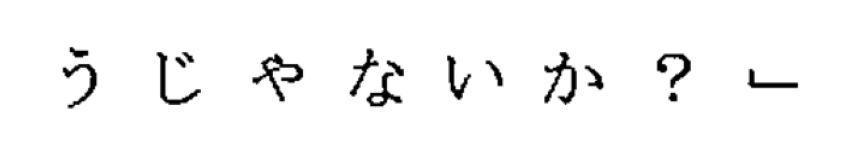

[{'literal': 'う', 'conf': 96}, {'literal': 'じ', 'conf': 96}, {'literal': 'や', 'conf': 96}, {'literal': 'な', 'conf': 96}, {'literal': 'い', 'conf': 95}, {'literal': 'か', 'conf': 95}, {'literal': '?', 'conf': 86}, {'literal': 'ー', 'conf': 91}]
[{'literal': 'う', 'conf': 81}, {'literal': 'ヒ', 'conf': 74}, {'literal': 'ゃ', 'conf': 80}, {'literal': 'な', 'conf': 92}, {'literal': 'い', 'conf': 92}, {'literal': 'か', 'conf': 95}, {'literal': '?', 'conf': 87}, {'literal': 'ー', 'conf': 81}]
うじやないか?ー
うヒゃないか?ー
Match(a=3, b=3, size=5)
8
{'0': [{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}], '1': [{'literal': 'そ', 'conf': 83}, {'literal': 'そ', 'conf': 87}], '2': [{'literal': 'ろ', 'conf': 83}, {'literal': 'ろ', 'conf': 81}], '3': [{'literal': 'そ', 'conf': 78}, {'literal': 'そ', 'conf': 90}], '4': [{'literal': 'ろ', 'conf': 72}, {'literal': 'ろ', 'conf': 15}, {'literal': 'ろ', 'conf': 94}, {'literal': 'ろ', 'conf': 94}], '5': [{'literal': '…', 'conf': 70}, {'literal': '…', 'conf': 70}], '6': [{'lit

In [77]:
import difflib

class aggregator(object):
    def __init__(self,size):
        self.collection = {f'{e}':[] for e in range(0,size)}
        print(self.collection)
    
    def insert(self,idx,elem0,elem1):
        for i,elm in enumerate(elem0):
            self.collection[str(idx+i)].append(elm)
        for i,elm in enumerate(elem1):
            self.collection[str(idx+i)].append(elm)
        print(self.collection)
            
    def complete(self):
        return self.collection
    
    def collapse(self):
        complete = []
        print(self.collection)
        for ii in range(0,len(self.collection)):
            items = self.collection[str(ii)]
            if items:
                items = sorted(items,key=lambda x:x['conf'],reverse=True)
                complete.append(items[0])
            else:
                complete.append([])
        return complete
        

count = len(elm)
a = aggregator(count)
datapoints
print(datapoints[0])
print(datapoints[1])
#text1 = "".join([x['literal'] if x['conf'] >= 90 else '〇' for x in datapoints[0]])
text1 = "".join([x['literal'] for x in datapoints[0]])
#text2 = "".join([x['literal'] if x['conf'] >= 90 else '〇' for x in datapoints[1]])
text2 = "".join([x['literal'] for x in datapoints[1]])
print(text1)
print(text2)
print(len(text1)==count)
print(len(text2)==count)

match1 = []
match2 = []

agreement = 0

unknown = 0

number_of_char = len(elm)
print(number_of_char)

synchronized = False
seq=difflib.SequenceMatcher(a=text1.lower(), b=text2.lower())
print(seq.get_matching_blocks())
#while not synchronized:
for block in seq.get_matching_blocks():
    #print(datapoints[0][block.a:block.a+block.size])
    #print(datapoints[1][block.b:block.b+block.size])
    if block.a == block.b and block.size > 1:
        a.insert(unknown,datapoints[0][unknown:min(block.a+block.size,number_of_char)],datapoints[1][unknown:min(block.b+block.size,number_of_char)])
        #a.collapse()
        unknown = block.a+block.size
    elif block.a - block.b != agreement and block.size > 1:
        image = drawCEGimage(imagesize,elm[max(0,unknown-1):min(block.a,block.b)+block.size],contours,hierarchy,20,30)
        cv2.imwrite('save_image.png',cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
        other = call_tesseract([None]*24)
        if len(other[0]) == len(other[1]):
            if other[0][-1]['literal'] == other[1][-1]['literal']:
                agreement = block.a-block.b
                a.insert(max(0,unknown-1),other[0],other[0])
                unknown = max(0,unknown-1)+len(other[0])
            else:
                text1 = "".join([x['literal'] for x in other[0]])
                text2 = "".join([x['literal'] for x in other[1]])
                seq=difflib.SequenceMatcher(a=text1.lower(), b=text2.lower())
                inter = next(x for x in seq.get_matching_blocks()[::-1] if x.size != 0)
                print(text1)
                print(text2)
                print(inter)
                print(inter.a+inter.size)
                if inter.a == inter.b:
                    a.insert(unknown-1,other[0][0:inter.a+inter.size],other[1][0:inter.b+inter.size])
                    unknown = unknown-1+len(other[0][0:inter.a+inter.size])
                    agreement = (block.a+inter.a)-(block.b+inter.b)
                    print(agreement)
        else:
            pass
    elif block.a - block.b == agreement and block.size > 1:
        image = drawCEGimage(imagesize,elm[max(0,unknown-1):min(block.a,block.b)+block.size],contours,hierarchy,20,30)
        cv2.imwrite('save_image.png',cv2.cvtColor(image,cv2.COLOR_RGB2BGR))
        other = call_tesseract(number_of_char)
        text1 = "".join([x['literal'] for x in other[0]])
        text2 = "".join([x['literal'] for x in other[1]])
        seq=difflib.SequenceMatcher(a=text1.lower(), b=text2.lower())
        inter = next(x for x in seq.get_matching_blocks()[::-1] if x.size != 0)
        print(text1)
        print(text2)
        print(inter)
        print(inter.a+inter.size)
        if inter.a == inter.b:
            a.insert(unknown-1,other[0][0:inter.a+inter.size],other[1][0:inter.b+inter.size])
            unknown = unknown-1+len(other[0][0:inter.a+inter.size])
            agreement = (block.a+inter.a)-(block.b+inter.b)
            print(agreement)
        #a.insert(unknown,datapoints[0][unknown:min(block.a+block.size,number_of_char)],datapoints[1][unknown:min(block.b+block.size,number_of_char)])
        #unknown = min(block.a,block.b)+block.size
print(a.collapse())
complete = a.complete()
print(complete)

In [82]:
text = ''
search = []
final = []
for a in complete.values():
    print(a)
    t = sorted(a,key=lambda x:x['conf'],reverse=True)
    s = [x['literal'] for x in t]
    if len(set(s)) == 1 and t[0]['conf'] > 90:
        text += s[0]
        final.append(s[0])
    elif len(set(s)) == 1:
        text += f'({s[0]})'
        final.append(s[0])
    else:
        t = sorted(a,key=lambda x:x['conf'],reverse=True)
        if t[0]['conf'] > t[1]['conf']+20 and t[0]['conf'] > 90:
            text += t[0]['literal']
            final.append(t[0]['literal'])
        else:
            text += f'({s})'
            final.append(s)
            search.append(a)
    print(text)
    print(search)
    print(final)

[{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}]
(['っ', 'つ'])
[[{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}]]
[['っ', 'つ']]
[{'literal': 'そ', 'conf': 83}, {'literal': 'そ', 'conf': 87}]
(['っ', 'つ'])(そ)
[[{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}]]
[['っ', 'つ'], 'そ']
[{'literal': 'ろ', 'conf': 83}, {'literal': 'ろ', 'conf': 81}]
(['っ', 'つ'])(そ)(ろ)
[[{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}]]
[['っ', 'つ'], 'そ', 'ろ']
[{'literal': 'そ', 'conf': 78}, {'literal': 'そ', 'conf': 90}]
(['っ', 'つ'])(そ)(ろ)(そ)
[[{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}]]
[['っ', 'つ'], 'そ', 'ろ', 'そ']
[{'literal': 'ろ', 'conf': 72}, {'literal': 'ろ', 'conf': 15}, {'literal': 'ろ', 'conf': 94}, {'literal': 'ろ', 'conf': 94}]
(['っ', 'つ'])(そ)(ろ)(そ)ろ
[[{'literal': 'っ', 'conf': 88}, {'literal': 'つ', 'conf': 69}]]
[['っ', 'つ'], 'そ', 'ろ', 'そ', 'ろ']
[{'literal': '…', 'conf': 70}, {'literal': '…', 'conf': 70}]
(['っ', 'つ'])(そ)(ろ)(そ)ろ(…)
[[{'literal': 'っ', 'conf'

In [83]:
final

[['っ', 'つ'],
 'そ',
 'ろ',
 'そ',
 'ろ',
 '…',
 '…',
 'ま',
 'た',
 '。',
 '戯',
 'れ',
 '合',
 'お',
 'う',
 'じ',
 ['や', 'ゃ'],
 'な',
 'い',
 'か',
 '?',
 'ー']